## Mortality Training
1. Load the MIMIC III Dataset
2. Normalize Data
3. Load into Pytorch Dataloader
4. Train
5. Evaluate

In [106]:
import itertools
from os import path

from comet_ml import Experiment
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import interpolation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from core.model import SAnD
from mimic3_benchmarks.mimic3benchmark.readers import InHospitalMortalityReader as Reader
from mimic3_benchmarks.mimic3models.preprocessing import Discretizer, Normalizer
from utils.ihm_utils import evaluate_predictions, load_data, save_results
from utils.functions import get_weights
from utils.trainer import NeuralNetworkClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task = "in-hospital-mortality"

comet_ml_info = {
    "api_key": "eQ3INeSsFGUYKahSdEtjhry42",
    "username": "samdoud",
    "project_name": "SAnD-in-hospital-mortality"
}
def get_experiment() -> Experiment:
    return Experiment(
    api_key=comet_ml_info["api_key"],
    project_name=comet_ml_info["project_name"],
    workspace=comet_ml_info["username"],
)

## Load Data
Using the [MimicIII Benchmark's](https://github.com/YerevaNN/mimic3-benchmarks) InHospitalMortalityReader and associated functions, load the data into memory.

If you are following along you will need to arrange the data following the directions on the link.

`Reader` is an alias for `InHospitalMortalityReader` from MIMIC-III Benchmarks


In [3]:
train_reader = Reader(dataset_dir=f"mimic3_benchmarks/data/{task}/train",
                              listfile=f"mimic3_benchmarks/data/{task}/train_listfile.csv")
val_reader = Reader(dataset_dir=f"mimic3_benchmarks/data/{task}/train",
                              listfile=f"mimic3_benchmarks/data/{task}/val_listfile.csv")
test_reader = Reader(dataset_dir=f"mimic3_benchmarks/data/{task}/test",
                              listfile=f"mimic3_benchmarks/data/{task}/test_listfile.csv")

### Example data

In [4]:
ex = pd.DataFrame.from_dict(train_reader.read_example(0)['X'])
ex.columns = train_reader.read_example(0)["header"]
ex

,Hours,Capillary refill rate,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH
0,0.2138888888888889,,71.0,,,,,,,94,,95,92.0,16,141.0,,,
1,0.46388888888888885,,71.0,,,,,,,91,,95,93.0,16,141.0,,,
2,0.7138888888888889,,,,,,,,,89,,,93.0,19,,,,
3,0.9638888888888889,,,,,,,,,89,,,94.0,13,,,,
4,1.1305555555555555,,,,,,,,,,,,,,,,,7.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,44.21388888888889,,58.0,,,,,,,103,,81,99.0,21,113.0,,,
67,45.21388888888889,,59.0,,4 Spontaneously,6 Obeys Commands,15,5 Oriented,,107,,81,97.0,22,116.0,,,
68,46.21388888888889,,61.0,,,,,,,100,,85,97.0,20,120.0,,,
69,47.21388888888889,,58.0,,,,,,,90,,83,100.0,18,123.0,37.0,,


### Normalize and Discretize data
From the MIMIC-III Benchmark repo

In [5]:
discretizer = Discretizer(timestep=1.0,
                          store_masks=True,
                          impute_strategy='previous',
                          start_time='zero')

discretizer_header = discretizer.transform(train_reader.read_example(0)["X"])[1].split(',')
cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]

In [6]:
normalizer = Normalizer(fields=cont_channels)  # choose here which columns to standardize
normalizer_state = 'train/modelsihm_ts1.0.input_str-previous.start_time-zero.normalizer'
normalizer.load_params(normalizer_state)

### Load the data into Tensors
The `load_data` method is customized from the MIMIC-III benchmark.

In [7]:
train_raw = load_data(train_reader, discretizer, normalizer)
val_raw = load_data(val_reader, discretizer, normalizer)
# return_names such that the prediction can be tied directly to a patient for evaluation
test_data = load_data(test_reader, discretizer, normalizer, return_names=True)
test_raw = test_data["data"]
test_names = test_data["names"]

N, seq_len, feature_count = train_raw[0].shape

### Load into standard Pytorch datasets

This data has already been collated for us. Shuffle is enabled on the train dataset to limit overfitting. This does come at the cost of reduced determinism.

In [8]:
batch_size = 256

train_ds = TensorDataset(train_raw[0], train_raw[1])
val_ds = TensorDataset(val_raw[0], val_raw[1])
test_ds = TensorDataset(test_raw[0], test_raw[1])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size)
print(len(test_raw[1]))
print(test_loader.dataset.tensors[1].shape)

3236
torch.Size([3236])


## Create model, Train, and Evaluate
Train the model, this will export results to Comet ML.
Creating is done in the same step such that a new experiment made each time
Evaluation is done in the same step such that the Comet ML experiment is also deleted.

### Paper IHM Module

In [232]:
n_heads = 8
factor = 12 # M
num_class = 2
num_layers = 4 # N
epochs = 28
betas = (0.9, 0.98)
lr = 5e-4
eps = 4e-09
weight_decay = 5e-4
dropout = 0.3
scores = {}

experiment = get_experiment()

clf = NeuralNetworkClassifier(
    SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
    nn.CrossEntropyLoss(),
    optim.Adam, optimizer_config={
        "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
    experiment=experiment,
)
# Score is the multiplication of AUPRC and AUROC
score = clf.fit(
    {
        "train": train_loader,
        "val": val_loader
    },
    validation=True,
    epochs=epochs,
    verbose=True,
)

preds = clf.evaluate(test_loader)

experiment.end()

file_path = 'results/modelstest_predictions.csv'
save_results(test_names, preds, test_raw[1], file_path)
pred_df = pd.read_csv(file_path, index_col=False)
list_df = pd.read_csv(f"mimic3_benchmarks/data/{task}/test_listfile.csv", index_col=False)

evaluate_predictions(pred_df, list_df, save_file="train/modelspaper_ihm.json")

clf.save_to_file("train/models/", "paper-ihm.pth")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/samdoud/sand-in-hospital-mortality/46eb8a5b33424377bf6676cdffca398d

Training - Epochs: 001/028:  99%|█████████▉| 14592/14681 [00:03<00:00, 4470.76it/s]

Train finished. Accuracy: 0.7767 MSE: 0.2233 AUROC: 0.5404 AUPRC: 0.2611


Training - Epochs: 001/028: 100%|██████████| 14681/14681 [00:03<00:00, 4117.96it/s]


Validation finished. Accuracy: 0.6124 MSE: 0.0851 AUROC: 0.7014 AUPRC: 0.5409


Training - Epochs: 002/028:  99%|█████████▉| 14592/14681 [00:03<00:00, 4592.87it/s]

Train finished. Accuracy: 0.8280 MSE: 0.1720 AUROC: 0.5966 AUPRC: 0.3568


Training - Epochs: 002/028: 100%|██████████| 14681/14681 [00:03<00:00, 4110.16it/s]


Validation finished. Accuracy: 0.1806 MSE: 0.1798 AUROC: 0.5214 AUPRC: 0.5653


Training - Epochs: 003/028:  99%|█████████▉| 14592/14681 [00:02<00:00, 4774.46it/s]

Train finished. Accuracy: 0.8023 MSE: 0.1977 AUROC: 0.5813 AUPRC: 0.3247


Training - Epochs: 003/028: 100%|██████████| 14681/14681 [00:03<00:00, 4807.96it/s]


Validation finished. Accuracy: 0.8731 MSE: 0.0279 AUROC: 0.5503 AUPRC: 0.4650


Training - Epochs: 004/028:  99%|█████████▉| 14592/14681 [00:02<00:00, 4686.31it/s]

Train finished. Accuracy: 0.8526 MSE: 0.1474 AUROC: 0.6231 AUPRC: 0.4195


Training - Epochs: 004/028: 100%|██████████| 14681/14681 [00:03<00:00, 4635.32it/s]


Validation finished. Accuracy: 0.7840 MSE: 0.0474 AUROC: 0.7368 AUPRC: 0.5314


Training - Epochs: 005/028:  51%|█████     | 7424/14681 [00:01<00:01, 5734.24it/s]

### Evaluate
Use the standard MIMIC-III Benchmark evaluation. This exports the stats shown in the paper to a JSON. Presumably, this is the same function the author used.

In [16]:
file_path = 'train/test_predictions.csv'
save_results(test_names, preds, test_raw[1], file_path)
pred_df = pd.read_csv(file_path, index_col=False)
list_df = pd.read_csv(f"mimic3_benchmarks/data/{task}/test_listfile.csv", index_col=False)

save_file_path = "results/paper_ihm_results.json"
evaluate_predictions(pred_df, list_df, save_file=save_file_path)

Saving the results in results/paper_ihm_results.json ...
{'n_iters': 10000, 'AUC of ROC': {'value': 0.590879195207719, 'mean': 0.590855437850811, 'median': 0.5908270261635298, 'std': 0.010888827680076834, '2.5% percentile': 0.5695861390411279, '97.5% percentile': 0.6126749928603985}, 'AUC of PRC': {'value': 0.3849364636030209, 'mean': 0.3850653890952727, 'median': 0.3855819542050518, 'std': 0.027183231088282897, '2.5% percentile': 0.3309164092162112, '97.5% percentile': 0.43716908687352685}, 'min(+P, Se)': {'value': 0.21390374331550802, 'mean': 0.21382195466640283, 'median': 0.21366253265363055, 'std': 0.021502527345097226, '2.5% percentile': 0.17201031206133247, '97.5% percentile': 0.2572178477690289}}


In [21]:
from json import load, dumps
with open(save_file_path) as fp:
    data = load(fp)
print(dumps(data, indent=4))

{
    "n_iters": 10000,
    "AUC of ROC": {
        "value": 0.590879195207719,
        "mean": 0.590855437850811,
        "median": 0.5908270261635298,
        "std": 0.010888827680076834,
        "2.5% percentile": 0.5695861390411279,
        "97.5% percentile": 0.6126749928603985
    },
    "AUC of PRC": {
        "value": 0.3849364636030209,
        "mean": 0.3850653890952727,
        "median": 0.3855819542050518,
        "std": 0.027183231088282897,
        "2.5% percentile": 0.3309164092162112,
        "97.5% percentile": 0.43716908687352685
    },
    "min(+P, Se)": {
        "value": 0.21390374331550802,
        "mean": 0.21382195466640283,
        "median": 0.21366253265363055,
        "std": 0.021502527345097226,
        "2.5% percentile": 0.17201031206133247,
        "97.5% percentile": 0.2572178477690289
    }
}


### Ablation: CrossEntropyLoss weighting

This block searches for the optimal weights to pass `nn.CrossEntropyLoss`.

The weight function is stored in `utils`, but placed here for clarity:
```
def get_weights(labels, level: Optional[int]=1) -> np.array:
    class_sample_count = np.array(
        [len(np.where(labels == t)[0]) for t in np.unique(labels)]
    )
    weight = (1.0 / class_sample_count ** (1/level))
    return weight
```


In [22]:
n_heads = 8
factor = 12 # M
num_class = 2
num_layers = 4 # N
epochs = 12
betas = (0.9, 0.98)
lr = 0.0005
eps = 4e-09
weight_decay = 5e-4
dropout = 0.3
scores = {}

experiment = get_experiment()

for iteration, level in enumerate(np.logspace(0, .75, 30)):
    clf = NeuralNetworkClassifier(
        SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
        nn.CrossEntropyLoss(weight=torch.tensor(get_weights(train_raw[1], level=level), dtype=torch.float32).to(device=device)),
        optim.Adam, optimizer_config={
            "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
        experiment=experiment,
        silent=True,
    )
    # Score is the multiplication of AUPRC and AUROC
    scores[level] = clf.fit(
        {
            "train": DataLoader(train_ds, batch_size=batch_size, shuffle=False),
            "val": val_loader
        },
        validation=True,
        epochs=epochs,
        verbose=True,
        level=iteration
    )
    print(scores[level])

    #clf.evaluate(test_loader)

experiment.end()
clf.save_to_file("train/models/", "loss-weighting-ihm.pth")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/sand-in-hospital-mortality/3785b6b57ad84a9d98648f1a61ec41af
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_AUPRC [1051]         : (0.06640625, 0.6198257215424157)
COMET INFO:     train_AUROC [1051]         : (0.4743264017379617, 0.8056440639166398)
COMET INFO:     train_MSE [1051]           : (0.1484375, 0.84765625)
COMET INFO:     train_accuracy [1051]      : (0.15234375, 0.8515625)
COMET INFO:     train_loss [1110]          : (0.23641610145568848, 136.97283935546875)
COMET INFO:     validate_AUPRC [234]       : (0.5000537114021315, 0.6297058127999262)
COMET INFO:     validate_AUPRCxAUROC [234] : (0.5411818649220399, 0.6742166567991064)
COMET INFO:     validate_AUROC [234]       : (0.5012294805107073, 0.7720959595959596)

(0.6314484787636439, 0.5789867687391947, 0.7363718988125424)


COMET WARNING: Cannot safely convert (0.641065987061497, 0.58596507712998, 0.751267806924531) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.641065987061497, 0.58596507712998, 0.751267806924531)


COMET WARNING: Cannot safely convert (0.6298933794425505, 0.5738982861991992, 0.7418835659292531) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6298933794425505, 0.5738982861991992, 0.7418835659292531)


COMET WARNING: Cannot safely convert (0.6347340754212848, 0.5785418028188942, 0.747118620626066) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6347340754212848, 0.5785418028188942, 0.747118620626066)


COMET WARNING: Cannot safely convert (0.6294618894223136, 0.5683173064294194, 0.751751055408102) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6294618894223136, 0.5683173064294194, 0.751751055408102)


COMET WARNING: Cannot safely convert (0.63124972844838, 0.5777167951660336, 0.7383155950130731) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.63124972844838, 0.5777167951660336, 0.7383155950130731)


COMET WARNING: Cannot safely convert (0.6250115148883051, 0.5749496010797328, 0.7251353425054499) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6250115148883051, 0.5749496010797328, 0.7251353425054499)


COMET WARNING: Cannot safely convert (0.6279338323041403, 0.5714228675707873, 0.7409557617708464) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6279338323041403, 0.5714228675707873, 0.7409557617708464)


COMET WARNING: Cannot safely convert (0.6168276966318725, 0.5538741410870898, 0.7427348077214382) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6168276966318725, 0.5538741410870898, 0.7427348077214382)


COMET WARNING: Cannot safely convert (0.6333770052169119, 0.5699831662353733, 0.7601646831799891) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6333770052169119, 0.5699831662353733, 0.7601646831799891)


COMET WARNING: Cannot safely convert (0.6217795454620704, 0.5782962898798487, 0.7087460566265139) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6217795454620704, 0.5782962898798487, 0.7087460566265139)


COMET WARNING: Cannot safely convert (0.6175895911731427, 0.5507768273374389, 0.7512151188445504) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6175895911731427, 0.5507768273374389, 0.7512151188445504)


COMET WARNING: Cannot safely convert (0.6298744298514347, 0.5728980137122601, 0.743827262129784) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6298744298514347, 0.5728980137122601, 0.743827262129784)


COMET WARNING: Cannot safely convert (0.6308669824047373, 0.5733450180857245, 0.745910911042763) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6308669824047373, 0.5733450180857245, 0.745910911042763)


COMET WARNING: Cannot safely convert (0.624443058560427, 0.5578661065745462, 0.7575969625321891) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.624443058560427, 0.5578661065745462, 0.7575969625321891)


COMET WARNING: Cannot safely convert (0.621863106791998, 0.5610073981899333, 0.7435745239961276) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.621863106791998, 0.5610073981899333, 0.7435745239961276)


COMET WARNING: Cannot safely convert (0.6186103920673649, 0.5558500671805867, 0.7441310418409215) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6186103920673649, 0.5558500671805867, 0.7441310418409215)


COMET WARNING: Cannot safely convert (0.6280656880129789, 0.5718548661145836, 0.7404873318097697) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6280656880129789, 0.5718548661145836, 0.7404873318097697)


COMET WARNING: Cannot safely convert (0.6218327299671291, 0.5808034229471637, 0.7038913440070602) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6218327299671291, 0.5808034229471637, 0.7038913440070602)


COMET WARNING: Cannot safely convert (0.620041809917083, 0.5634738728937624, 0.7331776839637242) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.620041809917083, 0.5634738728937624, 0.7331776839637242)


COMET WARNING: Cannot safely convert (0.6223980467853399, 0.5583513296799759, 0.7504914809960681) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6223980467853399, 0.5583513296799759, 0.7504914809960681)


COMET WARNING: Cannot safely convert (0.6218800916250127, 0.5580778150786736, 0.7494846447176907) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6218800916250127, 0.5580778150786736, 0.7494846447176907)


COMET WARNING: Cannot safely convert (0.6250399649923826, 0.566968046305068, 0.741183802367012) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6250399649923826, 0.566968046305068, 0.741183802367012)


COMET WARNING: Cannot safely convert (0.6257484916107567, 0.5681403286488387, 0.7409648175345931) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6257484916107567, 0.5681403286488387, 0.7409648175345931)


COMET WARNING: Cannot safely convert (0.6133704478098063, 0.5521924367983189, 0.7357264698327812) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6133704478098063, 0.5521924367983189, 0.7357264698327812)


COMET WARNING: Cannot safely convert (0.6086352727964587, 0.5422457528362247, 0.7414143127169267) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6086352727964587, 0.5422457528362247, 0.7414143127169267)


COMET WARNING: Cannot safely convert (0.6260277190209987, 0.5668496885442093, 0.7443837799745779) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6260277190209987, 0.5668496885442093, 0.7443837799745779)


COMET WARNING: Cannot safely convert (0.629897990900348, 0.5699630647767292, 0.7497678431475859) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.629897990900348, 0.5699630647767292, 0.7497678431475859)


COMET WARNING: Cannot safely convert (0.6201927204702549, 0.5554874842565588, 0.7496031928976469) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6201927204702549, 0.5554874842565588, 0.7496031928976469)


COMET WARNING: Cannot safely convert (0.6028765209821496, 0.5347926952886976, 0.7390441723690537) object to a scalar value, using its string representation for logging. Resulting string might be invalid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/sand-in-hospital-mortality/abf2335f85d24f7e9a68c8061267ae16
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     AUPRCxAUROC                 : (0.6028765209821496, 0.5347926952886976, 0.7390441723690537)
COMET INFO:     train_AUPRC [20880]         : (0.06640625, 0.7267984896661367)
COMET INFO:     train_AUROC [20880]         : (0.41931637519872816, 0.8348142663211158)
COMET INFO:     train_MSE [20880]           : (0.080078125, 0.8671875)
COMET INFO:     train_accuracy [20880]      : (0.1328125, 0.919921875)
COMET INFO:     train_loss 

(0.6028765209821496, 0.5347926952886976, 0.7390441723690537)


COMET INFO: Uploading 1 metrics, params and output messages


'train/models/loss-weighting-ihm.pth'

In [23]:
results = {level: score for level, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
max_level = list(results.keys())[0]
for level, score in results.items():
    print(f"{level}: AUROC/3 + 2/3 * AUPRC {score[0]}; AUPRC {score[1]}; AUROC {score[2]}")

1.0613584184128781: AUROC/3 + 2/3 * AUPRC 0.641065987061497; AUPRC 0.58596507712998; AUROC 0.751267806924531
1.1956008273486787: AUROC/3 + 2/3 * AUPRC 0.6347340754212848; AUPRC 0.5785418028188942; AUROC 0.747118620626066
1.709065158802393: AUROC/3 + 2/3 * AUPRC 0.6333770052169119; AUPRC 0.5699831662353733; AUROC 0.7601646831799891
1.0: AUROC/3 + 2/3 * AUPRC 0.6314484787636439; AUPRC 0.5789867687391947; AUROC 0.7363718988125424
1.3468224433499252: AUROC/3 + 2/3 * AUPRC 0.63124972844838; AUPRC 0.5777167951660336; AUROC 0.7383155950130731
2.1687370383932287: AUROC/3 + 2/3 * AUPRC 0.6308669824047373; AUPRC 0.5733450180857245; AUROC 0.745910911042763
4.992014774996221: AUROC/3 + 2/3 * AUPRC 0.629897990900348; AUPRC 0.5699630647767292; AUROC 0.7497678431475859
1.1264816923358862: AUROC/3 + 2/3 * AUPRC 0.6298933794425505; AUPRC 0.5738982861991992; AUROC 0.7418835659292531
2.043359717856942: AUROC/3 + 2/3 * AUPRC 0.6298744298514347; AUPRC 0.5728980137122601; AUROC 0.743827262129784
1.268961003

### Dropout Optimatization

The author claims that `dropout=0.3 is optimal. However, this is not the case. Anywhere from  ~0.4-~0.7 shows improved performance

In [24]:
n_heads = 8
factor = 12 # M
num_class = 2
num_layers = 4 # N
epochs = 15
betas = (0.9, 0.98)
lr = 4e-5
eps = 4e-09
weight_decay = 4e-5
scores = {}
experiment = get_experiment()

for dropout in np.arange(0, .841, .015):
    clf = NeuralNetworkClassifier(
        SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
        nn.CrossEntropyLoss(weight=torch.tensor(get_weights(train_raw[1], level=max_level), dtype=torch.float32).to(device=device)),
        optim.Adam, optimizer_config={
            "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
        experiment=experiment,
        silent=True
    )
    # Score is the multiplication of AUPRC and AUROC
    scores[dropout] = clf.fit(
        {
            "train": DataLoader(train_ds, batch_size=batch_size, shuffle=False),
            "val": val_loader
        },
        validation=True,
        epochs=epochs,
        verbose=False,
        level=iteration
    )
    print(scores[dropout])

    #clf.evaluate(test_loader)

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/samdoud/sand-in-hospital-mortality/6d125f5612f64a14bffed6c264600ce3

COMET WARNING: Cannot safely convert (0.6019338427105055, 0.5451470544956272, 0.7155074191402623) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6019338427105055, 0.5451470544956272, 0.7155074191402623)


COMET WARNING: Cannot safely convert (0.6104389435360835, 0.5500932862512595, 0.7311302581057317) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6104389435360835, 0.5500932862512595, 0.7311302581057317)


COMET WARNING: Cannot safely convert (0.62245381374209, 0.5680682546134116, 0.7312249319994468) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.62245381374209, 0.5680682546134116, 0.7312249319994468)


COMET WARNING: Cannot safely convert (0.611166758473496, 0.5585461097065295, 0.7164080560074291) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.611166758473496, 0.5585461097065295, 0.7164080560074291)


COMET WARNING: Cannot safely convert (0.6194899614195819, 0.5764223865599135, 0.7056251111389187) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6194899614195819, 0.5764223865599135, 0.7056251111389187)


COMET WARNING: Cannot safely convert (0.6198990159006008, 0.5681888987265903, 0.7233192502486219) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6198990159006008, 0.5681888987265903, 0.7233192502486219)


COMET WARNING: Cannot safely convert (0.6185856870550287, 0.5668820343398618, 0.7219929924853625) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6185856870550287, 0.5668820343398618, 0.7219929924853625)


COMET WARNING: Cannot safely convert (0.6155552258211414, 0.5777233199714626, 0.691219037520499) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6155552258211414, 0.5777233199714626, 0.691219037520499)


COMET WARNING: Cannot safely convert (0.60797870091071, 0.5404792179460159, 0.7429776668400982) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.60797870091071, 0.5404792179460159, 0.7429776668400982)


COMET WARNING: Cannot safely convert (0.6190044881436468, 0.5581354623668827, 0.7407425396971752) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6190044881436468, 0.5581354623668827, 0.7407425396971752)


COMET WARNING: Cannot safely convert (0.6017785657973489, 0.5446799241453539, 0.7159758491013388) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6017785657973489, 0.5446799241453539, 0.7159758491013388)


COMET WARNING: Cannot safely convert (0.610378796504475, 0.552504926251671, 0.7261265370100831) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.610378796504475, 0.552504926251671, 0.7261265370100831)


COMET WARNING: Cannot safely convert (0.6119674234523333, 0.5699447204047624, 0.6960128295474752) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6119674234523333, 0.5699447204047624, 0.6960128295474752)


COMET WARNING: Cannot safely convert (0.6099815229072074, 0.5708639642543812, 0.6882166402128598) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6099815229072074, 0.5708639642543812, 0.6882166402128598)


COMET WARNING: Cannot safely convert (0.6127816797559559, 0.5475770751770491, 0.7431908889137694) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6127816797559559, 0.5475770751770491, 0.7431908889137694)


COMET WARNING: Cannot safely convert (0.6152273935218527, 0.5738871133206421, 0.6979079539242741) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6152273935218527, 0.5738871133206421, 0.6979079539242741)


COMET WARNING: Cannot safely convert (0.6111669579757402, 0.5498545222656117, 0.7337918293959971) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6111669579757402, 0.5498545222656117, 0.7337918293959971)


COMET WARNING: Cannot safely convert (0.6043571675447386, 0.5526542039999192, 0.7077630946343776) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6043571675447386, 0.5526542039999192, 0.7077630946343776)


COMET WARNING: Cannot safely convert (0.6085662638737892, 0.5511321430988942, 0.7234345054235791) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6085662638737892, 0.5511321430988942, 0.7234345054235791)


COMET WARNING: Cannot safely convert (0.6195706420680591, 0.5599762993837591, 0.7387593274366591) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6195706420680591, 0.5599762993837591, 0.7387593274366591)


COMET WARNING: Cannot safely convert (0.621641528494, 0.5600621201875381, 0.7448003451069238) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.621641528494, 0.5600621201875381, 0.7448003451069238)


COMET WARNING: Cannot safely convert (0.6187768472679887, 0.5774911104536075, 0.7013483208967511) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6187768472679887, 0.5774911104536075, 0.7013483208967511)


COMET WARNING: Cannot safely convert (0.627855027137952, 0.5768817754125664, 0.7298015305887234) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.627855027137952, 0.5768817754125664, 0.7298015305887234)


COMET WARNING: Cannot safely convert (0.6197778890870832, 0.5604316505066169, 0.7384703662480159) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6197778890870832, 0.5604316505066169, 0.7384703662480159)


COMET WARNING: Cannot safely convert (0.6210726857152608, 0.5571708975508083, 0.7488762620441658) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6210726857152608, 0.5571708975508083, 0.7488762620441658)


COMET WARNING: Cannot safely convert (0.6293576698505055, 0.5752528749622081, 0.7375672596271001) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6293576698505055, 0.5752528749622081, 0.7375672596271001)


COMET WARNING: Cannot safely convert (0.6230838851844166, 0.5740870592287742, 0.7210775370957013) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6230838851844166, 0.5740870592287742, 0.7210775370957013)


COMET WARNING: Cannot safely convert (0.6269237425875249, 0.5670074188431873, 0.7467563900762002) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6269237425875249, 0.5670074188431873, 0.7467563900762002)


COMET WARNING: Cannot safely convert (0.6221445900762897, 0.5620425336717693, 0.742348702885331) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6221445900762897, 0.5620425336717693, 0.742348702885331)


COMET WARNING: Cannot safely convert (0.6187465361669557, 0.5551174234078196, 0.7460047616852282) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6187465361669557, 0.5551174234078196, 0.7460047616852282)


COMET WARNING: Cannot safely convert (0.6172505017537395, 0.5639773846438867, 0.7237967359734453) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6172505017537395, 0.5639773846438867, 0.7237967359734453)


COMET WARNING: Cannot safely convert (0.6236839747394711, 0.5686024684943435, 0.7338469872297266) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6236839747394711, 0.5686024684943435, 0.7338469872297266)


COMET WARNING: Cannot safely convert (0.626839544109096, 0.5651518818755588, 0.7502148685761706) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.626839544109096, 0.5651518818755588, 0.7502148685761706)


COMET WARNING: Cannot safely convert (0.6190830124899724, 0.5786879914063103, 0.699873054657297) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6190830124899724, 0.5786879914063103, 0.699873054657297)


COMET WARNING: Cannot safely convert (0.6328086311401, 0.5811015015419764, 0.7362228903363475) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6328086311401, 0.5811015015419764, 0.7362228903363475)


COMET WARNING: Cannot safely convert (0.6213637752226067, 0.5644697426036632, 0.7351518404604939) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6213637752226067, 0.5644697426036632, 0.7351518404604939)


COMET WARNING: Cannot safely convert (0.6279543946824654, 0.5701579136712545, 0.7435473567048874) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6279543946824654, 0.5701579136712545, 0.7435473567048874)


COMET WARNING: Cannot safely convert (0.6269176384982114, 0.5662058833813851, 0.7483411487318639) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6269176384982114, 0.5662058833813851, 0.7483411487318639)


COMET WARNING: Cannot safely convert (0.622656508458531, 0.5738049316848132, 0.7203596620059669) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.622656508458531, 0.5738049316848132, 0.7203596620059669)


COMET WARNING: Cannot safely convert (0.6358854061773676, 0.5744377103514258, 0.7587807978292511) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6358854061773676, 0.5744377103514258, 0.7587807978292511)


COMET WARNING: Cannot safely convert (0.6263398269702729, 0.5712599890772867, 0.7364995027562452) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6263398269702729, 0.5712599890772867, 0.7364995027562452)


COMET WARNING: Cannot safely convert (0.6329219707237038, 0.5800304596584662, 0.7387049928541791) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6329219707237038, 0.5800304596584662, 0.7387049928541791)


COMET WARNING: Cannot safely convert (0.6327646278131571, 0.580297863431835, 0.7376981565758016) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6327646278131571, 0.580297863431835, 0.7376981565758016)


COMET WARNING: Cannot safely convert (0.6255118429421777, 0.5653184832762578, 0.7458985622740175) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6255118429421777, 0.5653184832762578, 0.7458985622740175)


COMET WARNING: Cannot safely convert (0.6225181758838061, 0.5677511140730138, 0.7320522995053907) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6225181758838061, 0.5677511140730138, 0.7320522995053907)


COMET WARNING: Cannot safely convert (0.6263574649104546, 0.5636166257197721, 0.7518391432918196) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.6263574649104546, 0.5636166257197721, 0.7518391432918196)


COMET WARNING: Cannot safely convert (0.605740895245635, 0.5466903354723633, 0.7238420147921785) object to a scalar value, using its string representation for logging. Resulting string might be invalid


(0.605740895245635, 0.5466903354723633, 0.7238420147921785)


COMET WARNING: Cannot safely convert (0.6148392666042848, 0.5542009660694837, 0.7361158676738871) object to a scalar value, using its string representation for logging. Resulting string might be invalid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/sand-in-hospital-mortality/6d125f5612f64a14bffed6c264600ce3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     AUPRCxAUROC                 : (0.6148392666042848, 0.5542009660694837, 0.7361158676738871)
COMET INFO:     train_AUPRC [41760]         : (0.06640625, 0.6847360295746566)
COMET INFO:     train_AUROC [41760]         : (0.40827471306923363, 0.8540894346617238)
COMET INFO:     train_MSE [41760]           : (0.1015625, 0.8671875)
COMET INFO:     train_accuracy [41760]      : (0.1328125, 0.8984375)
COMET INFO:     train_loss [445

(0.6148392666042848, 0.5542009660694837, 0.7361158676738871)


COMET INFO: Uploading 1 metrics, params and output messages


In [25]:

results = {level: score for level, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
max_level = list(results.keys())[0]
for level, score in results.items():
    print(f"Dropout {level}: AUROC/3 + 2/3 * AUPRC {score[0]}; AUPRC {score[1]}; AUROC {score[2]}")
results

Dropout 0.6084: AUROC/3 + 2/3 * AUPRC 0.6358854061773676; AUPRC 0.5744377103514258; AUROC 0.7587807978292511
Dropout 0.6724000000000001: AUROC/3 + 2/3 * AUPRC 0.6329219707237038; AUPRC 0.5800304596584662; AUROC 0.7387049928541791
Dropout 0.4624000000000001: AUROC/3 + 2/3 * AUPRC 0.6328086311401; AUPRC 0.5811015015419764; AUROC 0.7362228903363475
Dropout 0.7055999999999999: AUROC/3 + 2/3 * AUPRC 0.6327646278131571; AUPRC 0.580297863431835; AUROC 0.7376981565758016
Dropout 0.25: AUROC/3 + 2/3 * AUPRC 0.6293576698505055; AUPRC 0.5752528749622081; AUROC 0.7375672596271001
Dropout 0.5184: AUROC/3 + 2/3 * AUPRC 0.6279543946824654; AUPRC 0.5701579136712545; AUROC 0.7435473567048874
Dropout 0.1936: AUROC/3 + 2/3 * AUPRC 0.627855027137952; AUPRC 0.5768817754125664; AUROC 0.7298015305887234
Dropout 0.2916: AUROC/3 + 2/3 * AUPRC 0.6269237425875249; AUPRC 0.5670074188431873; AUROC 0.7467563900762002
Dropout 0.5476: AUROC/3 + 2/3 * AUPRC 0.6269176384982114; AUPRC 0.5662058833813851; AUROC 0.7483411

{0.6084: (0.6358854061773676, 0.5744377103514258, 0.7587807978292511),
 0.6724000000000001: (0.6329219707237038,
  0.5800304596584662,
  0.7387049928541791),
 0.4624000000000001: (0.6328086311401, 0.5811015015419764, 0.7362228903363475),
 0.7055999999999999: (0.6327646278131571,
  0.580297863431835,
  0.7376981565758016),
 0.25: (0.6293576698505055, 0.5752528749622081, 0.7375672596271001),
 0.5184: (0.6279543946824654, 0.5701579136712545, 0.7435473567048874),
 0.1936: (0.627855027137952, 0.5768817754125664, 0.7298015305887234),
 0.2916: (0.6269237425875249, 0.5670074188431873, 0.7467563900762002),
 0.5476: (0.6269176384982114, 0.5662058833813851, 0.7483411487318639),
 0.4096: (0.626839544109096, 0.5651518818755588, 0.7502148685761706),
 0.81: (0.6263574649104546, 0.5636166257197721, 0.7518391432918196),
 0.6400000000000001: (0.6263398269702729,
  0.5712599890772867,
  0.7364995027562452),
 0.7395999999999999: (0.6255118429421777,
  0.5653184832762578,
  0.7458985622740175),
 0.3844: (0

#### Dropout Regression

dict_keys([0.6084, 0.6724000000000001, 0.4624000000000001, 0.7055999999999999, 0.25, 0.5184, 0.1936, 0.2916, 0.5476, 0.4096, 0.81, 0.6400000000000001, 0.7395999999999999, 0.3844, 0.27040000000000003, 0.5776, 0.7744, 0.0016, 0.31360000000000005, 0.16000000000000003, 0.4900000000000001, 0.2304, 0.010000000000000002, 0.2116, 0.1444, 0.0064, 0.43560000000000004, 0.0324, 0.17639999999999997, 0.3364, 0.0144, 0.36, 0.019600000000000003, 0.09, 0.8836000000000002, 0.07840000000000001, 0.0576, 0.1024, 0.0036, 0.0004, 0.0484, 0.06760000000000001, 0.1296, 0.0256, 0.8464, 0.11560000000000002, 0.0, 0.04000000000000001])

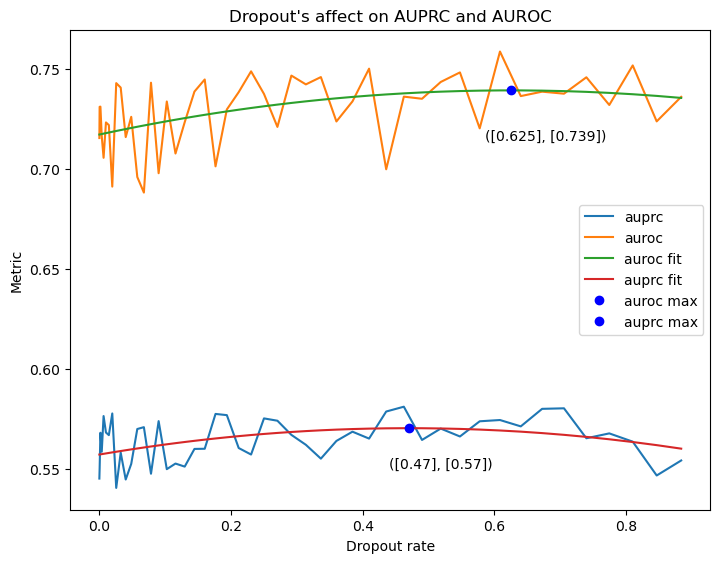

In [37]:
# plot the results from above

%matplotlib inline

#dropout = list(scores.keys())
#auprc = list(score[1] for score in scores.values())
#auroc = list(score[2] for score in scores.values())

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])


mixed, auprc, auroc = zip(*scores.values())
dropout = list(scores.keys())
coeffecients = np.polyfit(dropout, auroc, 2)
auroc_fit_fn = np.poly1d(coeffecients)
coeffecients = np.polyfit(dropout, auprc, 2)
auprc_fit_fn = np.poly1d(coeffecients)

auroc_deriv = auroc_fit_fn.deriv().r
auroc_max = auroc_deriv[auroc_deriv.imag==0].real
auprc_deriv = auprc_fit_fn.deriv().r
auprc_max = auprc_deriv[auprc_deriv.imag==0].real


ax.plot(dropout, auprc, label="auprc")
ax.plot(dropout, auroc, label="auroc")
ax.plot(dropout, auroc_fit_fn(dropout), label="auroc fit")
ax.plot(dropout, auprc_fit_fn(dropout), label="auprc fit")
ax.plot(auroc_max, auroc_fit_fn(auroc_max),'bo', label="auroc max")
ax.annotate(f"({auroc_max.round(3)}, {auroc_fit_fn(auroc_max).round(3)})",xy=(auroc_max-.04, auroc_fit_fn(auroc_max)-.025))
ax.plot(auprc_max, auprc_fit_fn(auprc_max),'bo', label="auprc max")
ax.annotate(f"({auprc_max.round(3)}, {auprc_fit_fn(auprc_max).round(3)})",xy=(auprc_max-.03, auprc_fit_fn(auprc_max)-.02))

ax.set_title("Dropout's affect on AUPRC and AUROC")
ax.set_xlabel("Dropout rate")
ax.set_ylabel("Metric")
plt.legend()

#### Lock Dropout

In [38]:
dropout = 0.5

### Vary layers, heads and dense interpolation factor
Since these two parameters are interlinked, we will scan a reasonable set.

High values will cause out of memory exceptions on our 4080 RTX, so this is somewhat limited.

In [129]:
n_heads = 8
num_class = 2
epochs = 12
betas = (0.9, 0.98)
lr = 4e-5
eps = 4e-09
weight_decay = 4e-5
scores = {}
experiment = get_experiment()

ranges = [
    np.rint(np.concatenate((np.arange(1,5), np.linspace(5, 8, 2)),axis=0)).astype(int),
    np.rint(np.concatenate((np.array([1]), np.linspace(2, 15, 5)), axis=0)).astype(int),
    np.array(np.power(2, np.arange(0, 6))).astype(int),
]

for parameters in list(itertools.product(*ranges)):
    num_layers, factor, n_heads = parameters
    clf = NeuralNetworkClassifier(
        SAnD(feature_count, seq_len, n_heads, factor, num_class, num_layers, dropout_rate=dropout),
        nn.CrossEntropyLoss(weight=torch.tensor(get_weights(train_raw[1], level=max_level), dtype=torch.float32).to(device=device)),
        optim.Adam, optimizer_config={
            "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
        experiment=experiment,
        silent=True
    )
    # Score is the multiplication of AUPRC and AUROC
    scores[parameters] = clf.fit(
        {
            "train": DataLoader(train_ds, batch_size=batch_size, shuffle=False),
            "val": val_loader
        },
        validation=True,
        epochs=epochs,
        verbose=False,
        level=iteration
    )
    print(f"{num_layers=} {factor=} {n_heads=} => {scores[parameters]}")

    #clf.evaluate(test_loader)

experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/sand-in-hospital-mortality/52877e0c96b0489985f5e05975c52a86
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     AUPRCxAUROC                : (0.6199388240633724, 0.572475182886684, 0.7148661064167494)
COMET INFO:     train_AUPRC [1392]         : (0.06640625, 0.5960990287162162)
COMET INFO:     train_AUROC [1392]         : (0.45447583605478337, 0.7299148463532026)
COMET INFO:     train_MSE [1392]           : (0.126953125, 0.78125)
COMET INFO:     train_accuracy [1392]      : (0.21875, 0.873046875)
COMET INFO:     train_loss [1510]          : (0.25722694396972656, 7.762701988220215)
COMET INFO:     validate_AUPRC [312]       : (0.4997209821428571, 0.6248218079159212)
COMET INFO:     validate_AUPRCxAUROC [312] : (0.5498139880952381, 0.

num_layers=1 factor=1 n_heads=1 => (0.6276294754779654, 0.5779639679539358, 0.7269604905260246)


COMET WARNING: Cannot safely convert (0.6231393269899992, 0.5772454769803854, 0.714927027009227) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=1 n_heads=2 => (0.6231393269899992, 0.5772454769803854, 0.714927027009227)


COMET WARNING: Cannot safely convert (0.6262433104156484, 0.574569164863447, 0.7295916015200511) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=1 n_heads=4 => (0.6262433104156484, 0.574569164863447, 0.7295916015200511)


COMET WARNING: Cannot safely convert (0.6341216952849905, 0.5824079688776824, 0.7375491480996068) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=1 n_heads=8 => (0.6341216952849905, 0.5824079688776824, 0.7375491480996068)


COMET WARNING: Cannot safely convert (0.6205295488045564, 0.5622267968463295, 0.7371350527210101) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=1 n_heads=16 => (0.6205295488045564, 0.5622267968463295, 0.7371350527210101)


COMET WARNING: Cannot safely convert (0.6240828102953488, 0.576935990570298, 0.7183764497454508) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=1 n_heads=32 => (0.6240828102953488, 0.576935990570298, 0.7183764497454508)


COMET WARNING: Cannot safely convert (0.6245320027668234, 0.5710455854380636, 0.7315048374243432) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=2 n_heads=1 => (0.6245320027668234, 0.5710455854380636, 0.7315048374243432)


COMET WARNING: Cannot safely convert (0.6183205607495894, 0.5718972218484502, 0.7111672385518681) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=2 n_heads=2 => (0.6183205607495894, 0.5718972218484502, 0.7111672385518681)


COMET WARNING: Cannot safely convert (0.6213394759721996, 0.5800087957466646, 0.7040008364232697) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=2 n_heads=4 => (0.6213394759721996, 0.5800087957466646, 0.7040008364232697)


COMET WARNING: Cannot safely convert (0.6248024961485903, 0.5634423257280523, 0.7475228369896665) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=2 n_heads=8 => (0.6248024961485903, 0.5634423257280523, 0.7475228369896665)


COMET WARNING: Cannot safely convert (0.6227324616435569, 0.5713470245583034, 0.7255033358140638) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=2 n_heads=16 => (0.6227324616435569, 0.5713470245583034, 0.7255033358140638)


COMET WARNING: Cannot safely convert (0.6160649196419379, 0.5608834559791711, 0.7264278469674716) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=2 n_heads=32 => (0.6160649196419379, 0.5608834559791711, 0.7264278469674716)


COMET WARNING: Cannot safely convert (0.6196336833719996, 0.5649301018409971, 0.7290408464340049) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=5 n_heads=1 => (0.6196336833719996, 0.5649301018409971, 0.7290408464340049)


COMET WARNING: Cannot safely convert (0.6147001840446715, 0.5686902584165006, 0.7067200353010137) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=5 n_heads=2 => (0.6147001840446715, 0.5686902584165006, 0.7067200353010137)


COMET WARNING: Cannot safely convert (0.6283366647610227, 0.5764179267963613, 0.7321741406903457) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=5 n_heads=4 => (0.6283366647610227, 0.5764179267963613, 0.7321741406903457)


COMET WARNING: Cannot safely convert (0.6132500875690882, 0.5592285168920715, 0.7212932289231215) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=5 n_heads=8 => (0.6132500875690882, 0.5592285168920715, 0.7212932289231215)


COMET WARNING: Cannot safely convert (0.6043696441864035, 0.5424160316424617, 0.7282768692742875) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=5 n_heads=16 => (0.6043696441864035, 0.5424160316424617, 0.7282768692742875)


COMET WARNING: Cannot safely convert (0.6068591613203392, 0.5475601251084684, 0.725457233744081) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=5 n_heads=32 => (0.6068591613203392, 0.5475601251084684, 0.725457233744081)


COMET WARNING: Cannot safely convert (0.6135249216434558, 0.5590476154782176, 0.7224795339739326) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=8 n_heads=1 => (0.6135249216434558, 0.5590476154782176, 0.7224795339739326)


COMET WARNING: Cannot safely convert (0.608471773372109, 0.5619803999041827, 0.7014545203079618) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=8 n_heads=2 => (0.608471773372109, 0.5619803999041827, 0.7014545203079618)


COMET WARNING: Cannot safely convert (0.601228176685205, 0.5446269617749773, 0.7144306065056607) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=8 n_heads=4 => (0.601228176685205, 0.5446269617749773, 0.7144306065056607)


COMET WARNING: Cannot safely convert (0.6032688051962001, 0.5602626557549422, 0.6892811040787161) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=8 n_heads=8 => (0.6032688051962001, 0.5602626557549422, 0.6892811040787161)


COMET WARNING: Cannot safely convert (0.614831703344131, 0.5697149048716336, 0.7050653002891258) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=8 n_heads=16 => (0.614831703344131, 0.5697149048716336, 0.7050653002891258)


COMET WARNING: Cannot safely convert (0.6100582159925056, 0.5577806398472122, 0.714613368283093) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=8 n_heads=32 => (0.6100582159925056, 0.5577806398472122, 0.714613368283093)


COMET WARNING: Cannot safely convert (0.6049837166692342, 0.5603027021204304, 0.694345745766842) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=12 n_heads=1 => (0.6049837166692342, 0.5603027021204304, 0.694345745766842)


COMET WARNING: Cannot safely convert (0.6109252842531148, 0.5560607334029933, 0.7206543859533578) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=12 n_heads=2 => (0.6109252842531148, 0.5560607334029933, 0.7206543859533578)


COMET WARNING: Cannot safely convert (0.6163606105778631, 0.5583764599041505, 0.7323289119252882) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=12 n_heads=4 => (0.6163606105778631, 0.5583764599041505, 0.7323289119252882)


COMET WARNING: Cannot safely convert (0.6146633653535796, 0.5766897206068823, 0.6906106548469741) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=12 n_heads=8 => (0.6146633653535796, 0.5766897206068823, 0.6906106548469741)


COMET WARNING: Cannot safely convert (0.61026761775587, 0.5587426412257688, 0.7133175708160726) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=12 n_heads=16 => (0.61026761775587, 0.5587426412257688, 0.7133175708160726)


COMET WARNING: Cannot safely convert (0.6085595577209539, 0.5461533509521047, 0.7333719712586523) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=12 n_heads=32 => (0.6085595577209539, 0.5461533509521047, 0.7333719712586523)


COMET WARNING: Cannot safely convert (0.6007244393196413, 0.5613860260639012, 0.6794012658311215) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=15 n_heads=1 => (0.6007244393196413, 0.5613860260639012, 0.6794012658311215)


COMET WARNING: Cannot safely convert (0.608365224520534, 0.5778204646646501, 0.6694547442323018) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=15 n_heads=2 => (0.608365224520534, 0.5778204646646501, 0.6694547442323018)


COMET WARNING: Cannot safely convert (0.6132941577828764, 0.5753887725186742, 0.6891049283112811) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=15 n_heads=4 => (0.6132941577828764, 0.5753887725186742, 0.6891049283112811)


COMET WARNING: Cannot safely convert (0.6219652531587359, 0.5645993382100178, 0.7366970830561721) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=15 n_heads=8 => (0.6219652531587359, 0.5645993382100178, 0.7366970830561721)


COMET WARNING: Cannot safely convert (0.5900774444612917, 0.5489760954313094, 0.6722801425212563) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=15 n_heads=16 => (0.5900774444612917, 0.5489760954313094, 0.6722801425212563)


COMET WARNING: Cannot safely convert (0.6050153509400751, 0.5526893890226511, 0.7096672747749232) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=1 factor=15 n_heads=32 => (0.6050153509400751, 0.5526893890226511, 0.7096672747749232)


COMET WARNING: Cannot safely convert (0.6252404361098317, 0.5723074622550023, 0.7311063838194907) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=1 n_heads=1 => (0.6252404361098317, 0.5723074622550023, 0.7311063838194907)


COMET WARNING: Cannot safely convert (0.6233166511225958, 0.5690583193474079, 0.7318333146729716) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=1 n_heads=2 => (0.6233166511225958, 0.5690583193474079, 0.7318333146729716)


COMET WARNING: Cannot safely convert (0.6267320105313178, 0.5705174787737215, 0.7391610740465104) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=1 n_heads=4 => (0.6267320105313178, 0.5705174787737215, 0.7391610740465104)


COMET WARNING: Cannot safely convert (0.6390045298343543, 0.5866112752141329, 0.7437910390747973) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=1 n_heads=8 => (0.6390045298343543, 0.5866112752141329, 0.7437910390747973)


COMET WARNING: Cannot safely convert (0.6295088832628419, 0.5726188969880215, 0.743288855812483) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=1 n_heads=16 => (0.6295088832628419, 0.5726188969880215, 0.743288855812483)


COMET WARNING: Cannot safely convert (0.6215499636473336, 0.5681679876807385, 0.7283139155805239) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=1 n_heads=32 => (0.6215499636473336, 0.5681679876807385, 0.7283139155805239)


COMET WARNING: Cannot safely convert (0.6270571189120924, 0.5829669820029576, 0.7152373927303621) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=2 n_heads=1 => (0.6270571189120924, 0.5829669820029576, 0.7152373927303621)


COMET WARNING: Cannot safely convert (0.6171801728473171, 0.5702566163512657, 0.7110272858394199) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=2 n_heads=2 => (0.6171801728473171, 0.5702566163512657, 0.7110272858394199)


COMET WARNING: Cannot safely convert (0.6311121525233895, 0.5815575344220502, 0.7302213887260682) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=2 n_heads=4 => (0.6311121525233895, 0.5815575344220502, 0.7302213887260682)


COMET WARNING: Cannot safely convert (0.6172109642543099, 0.5721370072460762, 0.7073588782707773) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=2 n_heads=8 => (0.6172109642543099, 0.5721370072460762, 0.7073588782707773)


COMET WARNING: Cannot safely convert (0.6317140823698104, 0.5743114766965717, 0.7465192937162879) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=2 n_heads=16 => (0.6317140823698104, 0.5743114766965717, 0.7465192937162879)


COMET WARNING: Cannot safely convert (0.624143738250316, 0.5731247599535676, 0.7261816948438129) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=2 n_heads=32 => (0.624143738250316, 0.5731247599535676, 0.7261816948438129)


COMET WARNING: Cannot safely convert (0.6252634707345359, 0.5734933310647575, 0.7288037500740926) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=5 n_heads=1 => (0.6252634707345359, 0.5734933310647575, 0.7288037500740926)


COMET WARNING: Cannot safely convert (0.6273570633709666, 0.5855750518423455, 0.7109210864282092) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=5 n_heads=2 => (0.6273570633709666, 0.5855750518423455, 0.7109210864282092)


COMET WARNING: Cannot safely convert (0.6060238595975975, 0.5760483587964768, 0.6659748611998393) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=5 n_heads=4 => (0.6060238595975975, 0.5760483587964768, 0.6659748611998393)


COMET WARNING: Cannot safely convert (0.6180423583579899, 0.5645370288467447, 0.7250530173804804) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=5 n_heads=8 => (0.6180423583579899, 0.5645370288467447, 0.7250530173804804)


COMET WARNING: Cannot safely convert (0.6053023881962668, 0.5650422695050275, 0.6858226255787456) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=5 n_heads=16 => (0.6053023881962668, 0.5650422695050275, 0.6858226255787456)


COMET WARNING: Cannot safely convert (0.6256617831445839, 0.5674521016022859, 0.74208114622918) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=5 n_heads=32 => (0.6256617831445839, 0.5674521016022859, 0.74208114622918)


COMET WARNING: Cannot safely convert (0.6234491560534466, 0.5774410174169061, 0.7154654333265278) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=8 n_heads=1 => (0.6234491560534466, 0.5774410174169061, 0.7154654333265278)


COMET WARNING: Cannot safely convert (0.6024639224871603, 0.5695526083762485, 0.6682865507089839) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=8 n_heads=2 => (0.6024639224871603, 0.5695526083762485, 0.6682865507089839)


COMET WARNING: Cannot safely convert (0.6051249116370281, 0.575004128192385, 0.6653664785263144) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=8 n_heads=4 => (0.6051249116370281, 0.575004128192385, 0.6653664785263144)


COMET WARNING: Cannot safely convert (0.6222149345076152, 0.5644704420941481, 0.7377039193345496) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=8 n_heads=8 => (0.6222149345076152, 0.5644704420941481, 0.7377039193345496)


COMET WARNING: Cannot safely convert (0.6194155773641823, 0.5721389847689827, 0.7139687625545816) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=8 n_heads=16 => (0.6194155773641823, 0.5721389847689827, 0.7139687625545816)


COMET WARNING: Cannot safely convert (0.6182505871163126, 0.567889638849354, 0.71897248365023) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=8 n_heads=32 => (0.6182505871163126, 0.567889638849354, 0.71897248365023)


COMET WARNING: Cannot safely convert (0.6168685842664842, 0.5700584366386667, 0.7104888795221191) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=12 n_heads=1 => (0.6168685842664842, 0.5700584366386667, 0.7104888795221191)


COMET WARNING: Cannot safely convert (0.6199736328927483, 0.5641092404769874, 0.7317024177242701) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=12 n_heads=2 => (0.6199736328927483, 0.5641092404769874, 0.7317024177242701)


COMET WARNING: Cannot safely convert (0.6089368254575869, 0.5646566624110423, 0.697497151550676) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=12 n_heads=4 => (0.6089368254575869, 0.5646566624110423, 0.697497151550676)


COMET WARNING: Cannot safely convert (0.6133765437005937, 0.5604797835758121, 0.7191700639501571) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=12 n_heads=8 => (0.6133765437005937, 0.5604797835758121, 0.7191700639501571)


COMET WARNING: Cannot safely convert (0.6188130588763835, 0.5691120420643201, 0.7182150925005103) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=12 n_heads=16 => (0.6188130588763835, 0.5691120420643201, 0.7182150925005103)


COMET WARNING: Cannot safely convert (0.6121500243936395, 0.5769425263986088, 0.6825650203837009) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=12 n_heads=32 => (0.6121500243936395, 0.5769425263986088, 0.6825650203837009)


COMET WARNING: Cannot safely convert (0.6073317647488394, 0.5656984940841449, 0.6905983060782286) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=15 n_heads=1 => (0.6073317647488394, 0.5656984940841449, 0.6905983060782286)


COMET WARNING: Cannot safely convert (0.6196933441796225, 0.5676461761645846, 0.7237876802096985) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=15 n_heads=2 => (0.6196933441796225, 0.5676461761645846, 0.7237876802096985)


COMET WARNING: Cannot safely convert (0.6131605138788618, 0.5701541252707649, 0.6991732910950559) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=15 n_heads=4 => (0.6131605138788618, 0.5701541252707649, 0.6991732910950559)


COMET WARNING: Cannot safely convert (0.6132601344824309, 0.5702138217899015, 0.6993527598674896) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=15 n_heads=8 => (0.6132601344824309, 0.5702138217899015, 0.6993527598674896)


COMET WARNING: Cannot safely convert (0.6202657511605192, 0.5657534809594474, 0.7292902915626626) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=15 n_heads=16 => (0.6202657511605192, 0.5657534809594474, 0.7292902915626626)


COMET WARNING: Cannot safely convert (0.6169475245089616, 0.5687563269710334, 0.7133299195848181) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=2 factor=15 n_heads=32 => (0.6169475245089616, 0.5687563269710334, 0.7133299195848181)


COMET WARNING: Cannot safely convert (0.6353683828299158, 0.5848559225723565, 0.7363933033450345) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=1 n_heads=1 => (0.6353683828299158, 0.5848559225723565, 0.7363933033450345)


COMET WARNING: Cannot safely convert (0.6300313619191616, 0.5808336923778765, 0.728426701001732) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=1 n_heads=2 => (0.6300313619191616, 0.5808336923778765, 0.728426701001732)


COMET WARNING: Cannot safely convert (0.6340420991144905, 0.5819646252551773, 0.738197046833117) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=1 n_heads=4 => (0.6340420991144905, 0.5819646252551773, 0.738197046833117)


COMET WARNING: Cannot safely convert (0.6287580965995041, 0.5771048207621883, 0.732064648274136) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=1 n_heads=8 => (0.6287580965995041, 0.5771048207621883, 0.732064648274136)


COMET WARNING: Cannot safely convert (0.6314657520418732, 0.5754142474441201, 0.7435687612373795) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=1 n_heads=16 => (0.6314657520418732, 0.5754142474441201, 0.7435687612373795)


COMET WARNING: Cannot safely convert (0.6362962527692213, 0.5781885093724217, 0.7525117395628207) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=1 n_heads=32 => (0.6362962527692213, 0.5781885093724217, 0.7525117395628207)


COMET WARNING: Cannot safely convert (0.62932199431907, 0.5712222348777765, 0.745521513201657) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=2 n_heads=1 => (0.62932199431907, 0.5712222348777765, 0.745521513201657)


COMET WARNING: Cannot safely convert (0.6161026857170552, 0.5791026741626268, 0.690102708825912) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=2 n_heads=2 => (0.6161026857170552, 0.5791026741626268, 0.690102708825912)


COMET WARNING: Cannot safely convert (0.6255722919195374, 0.5792447172446783, 0.7182274412692559) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=2 n_heads=4 => (0.6255722919195374, 0.5792447172446783, 0.7182274412692559)


COMET WARNING: Cannot safely convert (0.6267794335297738, 0.5778204638743548, 0.724697372840612) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=2 n_heads=8 => (0.6267794335297738, 0.5778204638743548, 0.724697372840612)


COMET WARNING: Cannot safely convert (0.630593835000883, 0.5757960950726344, 0.74018931485738) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=2 n_heads=16 => (0.630593835000883, 0.5757960950726344, 0.74018931485738)


COMET WARNING: Cannot safely convert (0.6249519938852948, 0.5728816351965743, 0.7290927112627357) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=2 n_heads=32 => (0.6249519938852948, 0.5728816351965743, 0.7290927112627357)


COMET WARNING: Cannot safely convert (0.6301323297141307, 0.5776756740465546, 0.735045641049283) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=5 n_heads=1 => (0.6301323297141307, 0.5776756740465546, 0.735045641049283)


COMET WARNING: Cannot safely convert (0.6263005725659485, 0.5797089975107772, 0.719483722676291) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=5 n_heads=2 => (0.6263005725659485, 0.5797089975107772, 0.719483722676291)


COMET WARNING: Cannot safely convert (0.6242949767065072, 0.5651829071127519, 0.742519115894018) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=5 n_heads=4 => (0.6242949767065072, 0.5651829071127519, 0.742519115894018)


COMET WARNING: Cannot safely convert (0.6189603436584807, 0.5833936889566386, 0.6900936530621653) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=5 n_heads=8 => (0.6189603436584807, 0.5833936889566386, 0.6900936530621653)


COMET WARNING: Cannot safely convert (0.618034259944098, 0.5665035656045497, 0.7210956486231946) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=5 n_heads=16 => (0.618034259944098, 0.5665035656045497, 0.7210956486231946)


COMET WARNING: Cannot safely convert (0.6250423421382233, 0.5710384731973243, 0.7330500800200215) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=5 n_heads=32 => (0.6250423421382233, 0.5710384731973243, 0.7330500800200215)


COMET WARNING: Cannot safely convert (0.6238925118285983, 0.5637320842599518, 0.7442133669658911) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=8 n_heads=1 => (0.6238925118285983, 0.5637320842599518, 0.7442133669658911)


COMET WARNING: Cannot safely convert (0.6268632304281623, 0.5656558413152348, 0.7492780086540172) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=8 n_heads=2 => (0.6268632304281623, 0.5656558413152348, 0.7492780086540172)


COMET WARNING: Cannot safely convert (0.6243813419042125, 0.5780316867171037, 0.7170806522784301) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=8 n_heads=4 => (0.6243813419042125, 0.5780316867171037, 0.7170806522784301)


COMET WARNING: Cannot safely convert (0.6237128414236178, 0.5740784035173034, 0.7229817172362468) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=8 n_heads=8 => (0.6237128414236178, 0.5740784035173034, 0.7229817172362468)


COMET WARNING: Cannot safely convert (0.6163486746706999, 0.5725682842387732, 0.7039094555345535) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=8 n_heads=16 => (0.6163486746706999, 0.5725682842387732, 0.7039094555345535)


COMET WARNING: Cannot safely convert (0.6253110948043721, 0.5772879209462592, 0.7213574425205977) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=8 n_heads=32 => (0.6253110948043721, 0.5772879209462592, 0.7213574425205977)


COMET WARNING: Cannot safely convert (0.6230315362465767, 0.5805179834533559, 0.7080586418330183) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=12 n_heads=1 => (0.6230315362465767, 0.5805179834533559, 0.7080586418330183)


COMET WARNING: Cannot safely convert (0.6226689385171695, 0.5671498905171152, 0.7337070345172784) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=12 n_heads=2 => (0.6226689385171695, 0.5671498905171152, 0.7337070345172784)


COMET WARNING: Cannot safely convert (0.6232007022952039, 0.5652312186857966, 0.7391396695140183) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=12 n_heads=4 => (0.6232007022952039, 0.5652312186857966, 0.7391396695140183)


COMET WARNING: Cannot safely convert (0.6274795509108042, 0.5694806361918748, 0.7434773803486633) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=12 n_heads=8 => (0.6274795509108042, 0.5694806361918748, 0.7434773803486633)


COMET WARNING: Cannot safely convert (0.6127052109890402, 0.5729403517022488, 0.6922349295626231) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=12 n_heads=16 => (0.6127052109890402, 0.5729403517022488, 0.6922349295626231)


COMET WARNING: Cannot safely convert (0.6193063443463789, 0.5758230115833538, 0.706273009872429) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=12 n_heads=32 => (0.6193063443463789, 0.5758230115833538, 0.706273009872429)


COMET WARNING: Cannot safely convert (0.6054971368981983, 0.574017223488462, 0.6684569637176709) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=15 n_heads=1 => (0.6054971368981983, 0.574017223488462, 0.6684569637176709)


COMET WARNING: Cannot safely convert (0.6164841232897462, 0.5777159041730131, 0.6940205615232125) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=15 n_heads=2 => (0.6164841232897462, 0.5777159041730131, 0.6940205615232125)


COMET WARNING: Cannot safely convert (0.6263473676024824, 0.5692378694388535, 0.7405663639297404) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=15 n_heads=4 => (0.6263473676024824, 0.5692378694388535, 0.7405663639297404)


COMET WARNING: Cannot safely convert (0.6238138781952288, 0.578132581223901, 0.7151764721378847) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=15 n_heads=8 => (0.6238138781952288, 0.578132581223901, 0.7151764721378847)


COMET WARNING: Cannot safely convert (0.6247297251745563, 0.5646837129421266, 0.7448217496394158) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=15 n_heads=16 => (0.6247297251745563, 0.5646837129421266, 0.7448217496394158)


COMET WARNING: Cannot safely convert (0.6228650416005164, 0.5794408739783217, 0.709713376844906) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=3 factor=15 n_heads=32 => (0.6228650416005164, 0.5794408739783217, 0.709713376844906)


COMET WARNING: Cannot safely convert (0.6366868400989818, 0.5810070477562365, 0.7480464247844728) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=1 n_heads=1 => (0.6366868400989818, 0.5810070477562365, 0.7480464247844728)


COMET WARNING: Cannot safely convert (0.6300195986800843, 0.5775963118817017, 0.7348661722768495) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=1 n_heads=2 => (0.6300195986800843, 0.5775963118817017, 0.7348661722768495)


COMET WARNING: Cannot safely convert (0.6375244525478907, 0.5809874269925719, 0.7505985036585286) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=1 n_heads=4 => (0.6375244525478907, 0.5809874269925719, 0.7505985036585286)


COMET WARNING: Cannot safely convert (0.6386206943752829, 0.5886970933157909, 0.7384678964942669) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=1 n_heads=8 => (0.6386206943752829, 0.5886970933157909, 0.7384678964942669)


COMET WARNING: Cannot safely convert (0.6311887147327915, 0.5791902752183217, 0.7351855937617313) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=1 n_heads=16 => (0.6311887147327915, 0.5791902752183217, 0.7351855937617313)


COMET WARNING: Cannot safely convert (0.6353298353700653, 0.5824954676371826, 0.7409985708358306) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=1 n_heads=32 => (0.6353298353700653, 0.5824954676371826, 0.7409985708358306)


COMET WARNING: Cannot safely convert (0.6224629495935297, 0.5791966735127088, 0.7089955017551717) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=2 n_heads=1 => (0.6224629495935297, 0.5791966735127088, 0.7089955017551717)


COMET WARNING: Cannot safely convert (0.6241516506822774, 0.5807076587193335, 0.7110396346081653) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=2 n_heads=2 => (0.6241516506822774, 0.5807076587193335, 0.7110396346081653)


COMET WARNING: Cannot safely convert (0.6271907438627192, 0.5772511243229619, 0.727069982942234) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=2 n_heads=4 => (0.6271907438627192, 0.5772511243229619, 0.727069982942234)


COMET WARNING: Cannot safely convert (0.6248743372943871, 0.5712898840707588, 0.732043243741644) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=2 n_heads=8 => (0.6248743372943871, 0.5712898840707588, 0.732043243741644)


COMET WARNING: Cannot safely convert (0.6299039167047267, 0.5824767283405453, 0.7247582934330894) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=2 n_heads=16 => (0.6299039167047267, 0.5824767283405453, 0.7247582934330894)


COMET WARNING: Cannot safely convert (0.6238492385743293, 0.5705598454666232, 0.7304280247897416) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=2 n_heads=32 => (0.6238492385743293, 0.5705598454666232, 0.7304280247897416)


COMET WARNING: Cannot safely convert (0.5976001340345188, 0.5750827685419158, 0.6426348650197251) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=5 n_heads=1 => (0.5976001340345188, 0.5750827685419158, 0.6426348650197251)


COMET WARNING: Cannot safely convert (0.6264471686469518, 0.5751091671909405, 0.7291231715589745) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=5 n_heads=2 => (0.6264471686469518, 0.5751091671909405, 0.7291231715589745)


COMET WARNING: Cannot safely convert (0.6219722649691112, 0.5704211864971807, 0.7250744219129724) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=5 n_heads=4 => (0.6219722649691112, 0.5704211864971807, 0.7250744219129724)


COMET WARNING: Cannot safely convert (0.6179928566591683, 0.5730953889028182, 0.7077877921718685) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=5 n_heads=8 => (0.6179928566591683, 0.5730953889028182, 0.7077877921718685)


COMET WARNING: Cannot safely convert (0.6193856081131117, 0.5744316528158868, 0.7092935187075615) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=5 n_heads=16 => (0.6193856081131117, 0.5744316528158868, 0.7092935187075615)


COMET WARNING: Cannot safely convert (0.6377992356548272, 0.5765206031216568, 0.7603565007211681) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=5 n_heads=32 => (0.6377992356548272, 0.5765206031216568, 0.7603565007211681)


COMET WARNING: Cannot safely convert (0.6177404212112099, 0.5684004294287276, 0.7164204047761744) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=8 n_heads=1 => (0.6177404212112099, 0.5684004294287276, 0.7164204047761744)


COMET WARNING: Cannot safely convert (0.6315614009973121, 0.5724079615959438, 0.7498682798000488) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=8 n_heads=2 => (0.6315614009973121, 0.5724079615959438, 0.7498682798000488)


COMET WARNING: Cannot safely convert (0.6261404514727519, 0.5800619683963879, 0.7182974176254799) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=8 n_heads=4 => (0.6261404514727519, 0.5800619683963879, 0.7182974176254799)


COMET WARNING: Cannot safely convert (0.623587529814725, 0.5674859530069588, 0.7357906834302574) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=8 n_heads=8 => (0.623587529814725, 0.5674859530069588, 0.7357906834302574)


COMET WARNING: Cannot safely convert (0.6150025280231851, 0.5652958980431946, 0.7144157879831662) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=8 n_heads=16 => (0.6150025280231851, 0.5652958980431946, 0.7144157879831662)


COMET WARNING: Cannot safely convert (0.6301561729545984, 0.571287197780258, 0.7478941233032791) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=8 n_heads=32 => (0.6301561729545984, 0.571287197780258, 0.7478941233032791)


COMET WARNING: Cannot safely convert (0.62142565366239, 0.5771175534468178, 0.7100418540935345) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=12 n_heads=1 => (0.62142565366239, 0.5771175534468178, 0.7100418540935345)


COMET WARNING: Cannot safely convert (0.6198226395918283, 0.5827829527161144, 0.6939020133432563) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=12 n_heads=2 => (0.6198226395918283, 0.5827829527161144, 0.6939020133432563)


COMET WARNING: Cannot safely convert (0.620949296994828, 0.5802858829646631, 0.7022761250551579) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=12 n_heads=4 => (0.620949296994828, 0.5802858829646631, 0.7022761250551579)


COMET WARNING: Cannot safely convert (0.6235258726564609, 0.5714953166211699, 0.7275869847270429) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=12 n_heads=8 => (0.6235258726564609, 0.5714953166211699, 0.7275869847270429)


COMET WARNING: Cannot safely convert (0.626036857315193, 0.5799963115462663, 0.7181179488530464) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=12 n_heads=16 => (0.626036857315193, 0.5799963115462663, 0.7181179488530464)


COMET WARNING: Cannot safely convert (0.6159219787107716, 0.5732940141221253, 0.7011779078880642) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=12 n_heads=32 => (0.6159219787107716, 0.5732940141221253, 0.7011779078880642)


COMET WARNING: Cannot safely convert (0.6183161236689263, 0.5841520703404186, 0.6866442303259417) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=15 n_heads=1 => (0.6183161236689263, 0.5841520703404186, 0.6866442303259417)


COMET WARNING: Cannot safely convert (0.6195902515823891, 0.5660162710292803, 0.7267382126886068) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=15 n_heads=2 => (0.6195902515823891, 0.5660162710292803, 0.7267382126886068)


COMET WARNING: Cannot safely convert (0.6151066798795214, 0.5703615846552575, 0.7045968703280492) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=15 n_heads=4 => (0.6151066798795214, 0.5703615846552575, 0.7045968703280492)


COMET WARNING: Cannot safely convert (0.602697804627216, 0.5720068385293038, 0.6640797368230404) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=15 n_heads=8 => (0.602697804627216, 0.5720068385293038, 0.6640797368230404)


COMET WARNING: Cannot safely convert (0.6197315294006707, 0.5710129240199322, 0.7171687401621476) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=15 n_heads=16 => (0.6197315294006707, 0.5710129240199322, 0.7171687401621476)


COMET WARNING: Cannot safely convert (0.6238221241219762, 0.563950452066774, 0.7435654682323808) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=4 factor=15 n_heads=32 => (0.6238221241219762, 0.563950452066774, 0.7435654682323808)


COMET WARNING: Cannot safely convert (0.6267166041218216, 0.5733551672521688, 0.7334394778611273) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=1 n_heads=1 => (0.6267166041218216, 0.5733551672521688, 0.7334394778611273)


COMET WARNING: Cannot safely convert (0.6372258658470173, 0.5780726745715496, 0.755532248397953) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=1 n_heads=2 => (0.6372258658470173, 0.5780726745715496, 0.755532248397953)


COMET WARNING: Cannot safely convert (0.6296950021678365, 0.5797709884035952, 0.729543029696319) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=1 n_heads=4 => (0.6296950021678365, 0.5797709884035952, 0.729543029696319)


COMET WARNING: Cannot safely convert (0.6376560536745126, 0.5807711449295327, 0.7514258711644723) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=1 n_heads=8 => (0.6376560536745126, 0.5807711449295327, 0.7514258711644723)


COMET WARNING: Cannot safely convert (0.6315007352607661, 0.5700295593938461, 0.754443086994606) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=1 n_heads=16 => (0.6315007352607661, 0.5700295593938461, 0.754443086994606)


COMET WARNING: Cannot safely convert (0.636702061308703, 0.5834769939105376, 0.7431521961050338) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=1 n_heads=32 => (0.636702061308703, 0.5834769939105376, 0.7431521961050338)


COMET WARNING: Cannot safely convert (0.6289377326125559, 0.5870137236644494, 0.7127857505087691) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=2 n_heads=1 => (0.6289377326125559, 0.5870137236644494, 0.7127857505087691)


COMET WARNING: Cannot safely convert (0.6261002953725953, 0.575685427944, 0.7269300302297859) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=2 n_heads=2 => (0.6261002953725953, 0.575685427944, 0.7269300302297859)


COMET WARNING: Cannot safely convert (0.6285719857237386, 0.5829761645350143, 0.7197636281011874) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=2 n_heads=4 => (0.6285719857237386, 0.5829761645350143, 0.7197636281011874)


COMET WARNING: Cannot safely convert (0.634613396233581, 0.5784505184235553, 0.7469391518536325) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=2 n_heads=8 => (0.634613396233581, 0.5784505184235553, 0.7469391518536325)


COMET WARNING: Cannot safely convert (0.6349816594722317, 0.5815047738293556, 0.741935430757984) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=2 n_heads=16 => (0.6349816594722317, 0.5815047738293556, 0.741935430757984)


COMET WARNING: Cannot safely convert (0.6372254627378946, 0.5890118441394426, 0.7336526999347984) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=2 n_heads=32 => (0.6372254627378946, 0.5890118441394426, 0.7336526999347984)


COMET WARNING: Cannot safely convert (0.6006532650972058, 0.5783909535807916, 0.6451778881300342) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=5 n_heads=1 => (0.6006532650972058, 0.5783909535807916, 0.6451778881300342)


COMET WARNING: Cannot safely convert (0.6076850637180641, 0.5810770137031129, 0.6609011637479665) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=5 n_heads=2 => (0.6076850637180641, 0.5810770137031129, 0.6609011637479665)


COMET WARNING: Cannot safely convert (0.6296357176505414, 0.5874325605179098, 0.7140420319158044) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=5 n_heads=4 => (0.6296357176505414, 0.5874325605179098, 0.7140420319158044)


COMET WARNING: Cannot safely convert (0.6263808274431085, 0.5716454391532954, 0.735851604022735) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=5 n_heads=8 => (0.6263808274431085, 0.5716454391532954, 0.735851604022735)


COMET WARNING: Cannot safely convert (0.6143460190104777, 0.582055491960068, 0.6789270731112971) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=5 n_heads=16 => (0.6143460190104777, 0.582055491960068, 0.6789270731112971)


COMET WARNING: Cannot safely convert (0.6201023675796857, 0.5695555087316999, 0.7211960852756574) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=5 n_heads=32 => (0.6201023675796857, 0.5695555087316999, 0.7211960852756574)


COMET WARNING: Cannot safely convert (0.6335217640463442, 0.5848525302216004, 0.7308602316958317) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=8 n_heads=1 => (0.6335217640463442, 0.5848525302216004, 0.7308602316958317)


COMET WARNING: Cannot safely convert (0.6269380775789059, 0.5635156966221836, 0.7537828394923505) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=8 n_heads=2 => (0.6269380775789059, 0.5635156966221836, 0.7537828394923505)


COMET WARNING: Cannot safely convert (0.6183686573924643, 0.5738035705970838, 0.7074988309832254) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=8 n_heads=4 => (0.6183686573924643, 0.5738035705970838, 0.7074988309832254)


COMET WARNING: Cannot safely convert (0.6289750236890463, 0.5805602126478434, 0.7258046457714523) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=8 n_heads=8 => (0.6289750236890463, 0.5805602126478434, 0.7258046457714523)


COMET WARNING: Cannot safely convert (0.6110159480483037, 0.5752216538506125, 0.6826045364436863) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=8 n_heads=16 => (0.6110159480483037, 0.5752216538506125, 0.6826045364436863)


COMET WARNING: Cannot safely convert (0.6322505908986279, 0.5807131131108522, 0.7353255464741795) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=8 n_heads=32 => (0.6322505908986279, 0.5807131131108522, 0.7353255464741795)


COMET WARNING: Cannot safely convert (0.6266485429140625, 0.5768864948310607, 0.726172639080066) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=12 n_heads=1 => (0.6266485429140625, 0.5768864948310607, 0.726172639080066)


COMET WARNING: Cannot safely convert (0.6147841185296995, 0.5828571218332224, 0.6786381119226539) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=12 n_heads=2 => (0.6147841185296995, 0.5828571218332224, 0.6786381119226539)


COMET WARNING: Cannot safely convert (0.618781396667311, 0.5764910982742136, 0.703361993453506) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=12 n_heads=4 => (0.618781396667311, 0.5764910982742136, 0.703361993453506)


COMET WARNING: Cannot safely convert (0.6266591760705364, 0.5803913833619808, 0.7191947614876479) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=12 n_heads=8 => (0.6266591760705364, 0.5803913833619808, 0.7191947614876479)


COMET WARNING: Cannot safely convert (0.6218565509472012, 0.5719920848624201, 0.7215854831167633) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=12 n_heads=16 => (0.6218565509472012, 0.5719920848624201, 0.7215854831167633)


COMET WARNING: Cannot safely convert (0.6130315382175486, 0.5843058148047373, 0.6704829850431713) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=12 n_heads=32 => (0.6130315382175486, 0.5843058148047373, 0.6704829850431713)


COMET WARNING: Cannot safely convert (0.6336546083295076, 0.5764344141901591, 0.7480949966082049) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=15 n_heads=1 => (0.6336546083295076, 0.5764344141901591, 0.7480949966082049)


COMET WARNING: Cannot safely convert (0.6266923664724768, 0.5662816590957553, 0.7475137812259199) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=15 n_heads=2 => (0.6266923664724768, 0.5662816590957553, 0.7475137812259199)


COMET WARNING: Cannot safely convert (0.6253646686286647, 0.5791127510808027, 0.7178685037243887) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=15 n_heads=4 => (0.6253646686286647, 0.5791127510808027, 0.7178685037243887)


COMET WARNING: Cannot safely convert (0.6217482918583296, 0.5817733364485586, 0.7016982026778718) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=15 n_heads=8 => (0.6217482918583296, 0.5817733364485586, 0.7016982026778718)


COMET WARNING: Cannot safely convert (0.6231562334269278, 0.578187938527939, 0.7130928232249056) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=15 n_heads=16 => (0.6231562334269278, 0.578187938527939, 0.7130928232249056)


COMET WARNING: Cannot safely convert (0.6203049181995731, 0.5750030084696279, 0.7109087376594637) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=5 factor=15 n_heads=32 => (0.6203049181995731, 0.5750030084696279, 0.7109087376594637)


COMET WARNING: Cannot safely convert (0.6321552066656697, 0.5772955549157514, 0.7418745101655064) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=1 n_heads=1 => (0.6321552066656697, 0.5772955549157514, 0.7418745101655064)


COMET WARNING: Cannot safely convert (0.6278462931392208, 0.5772823581674414, 0.7289741630827795) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=1 n_heads=2 => (0.6278462931392208, 0.5772823581674414, 0.7289741630827795)


COMET WARNING: Cannot safely convert (0.6322311078273531, 0.5744041279712635, 0.7478850675395325) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=1 n_heads=4 => (0.6322311078273531, 0.5744041279712635, 0.7478850675395325)


COMET WARNING: Cannot safely convert (0.6303549878948438, 0.5810499281827494, 0.728965107319033) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=1 n_heads=8 => (0.6303549878948438, 0.5810499281827494, 0.728965107319033)


COMET WARNING: Cannot safely convert (0.6358286725851063, 0.5790521397219202, 0.7493817383114789) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=1 n_heads=16 => (0.6358286725851063, 0.5790521397219202, 0.7493817383114789)


COMET WARNING: Cannot safely convert (0.6484558891065051, 0.5919000820050228, 0.76156750330947) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=1 n_heads=32 => (0.6484558891065051, 0.5919000820050228, 0.76156750330947)


COMET WARNING: Cannot safely convert (0.6258418796381533, 0.5822209357266505, 0.713083767461159) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=2 n_heads=1 => (0.6258418796381533, 0.5822209357266505, 0.713083767461159)


COMET WARNING: Cannot safely convert (0.6198340697436382, 0.5724077857932994, 0.714686637644316) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=2 n_heads=2 => (0.6198340697436382, 0.5724077857932994, 0.714686637644316)


COMET WARNING: Cannot safely convert (0.6290888443697593, 0.5833027805729614, 0.7206609719633554) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=2 n_heads=4 => (0.6290888443697593, 0.5833027805729614, 0.7206609719633554)


COMET WARNING: Cannot safely convert (0.629482416364484, 0.5822034153750485, 0.7240404183433551) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=2 n_heads=8 => (0.629482416364484, 0.5822034153750485, 0.7240404183433551)


COMET WARNING: Cannot safely convert (0.6269831245503423, 0.5690949341960491, 0.7427595052589289) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=2 n_heads=16 => (0.6269831245503423, 0.5690949341960491, 0.7427595052589289)


COMET WARNING: Cannot safely convert (0.6261062383387981, 0.5733019742616893, 0.7317147664930156) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=2 n_heads=32 => (0.6261062383387981, 0.5733019742616893, 0.7317147664930156)


COMET WARNING: Cannot safely convert (0.6249221773660882, 0.5774771660866725, 0.7198121999249195) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=5 n_heads=1 => (0.6249221773660882, 0.5774771660866725, 0.7198121999249195)


COMET WARNING: Cannot safely convert (0.6170252812866436, 0.570617431535661, 0.7098409807886088) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=5 n_heads=2 => (0.6170252812866436, 0.570617431535661, 0.7098409807886088)


COMET WARNING: Cannot safely convert (0.6177199066935157, 0.5778996141186603, 0.6973604918432266) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=5 n_heads=4 => (0.6177199066935157, 0.5778996141186603, 0.6973604918432266)


COMET WARNING: Cannot safely convert (0.6251142414209832, 0.5655494485004099, 0.7442438272621298) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=5 n_heads=8 => (0.6251142414209832, 0.5655494485004099, 0.7442438272621298)


COMET WARNING: Cannot safely convert (0.6278684530180612, 0.573447963614633, 0.7367094318249174) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=5 n_heads=16 => (0.6278684530180612, 0.573447963614633, 0.7367094318249174)


COMET WARNING: Cannot safely convert (0.6274030713176946, 0.5661066651046661, 0.7499958837437515) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=5 n_heads=32 => (0.6274030713176946, 0.5661066651046661, 0.7499958837437515)


COMET WARNING: Cannot safely convert (0.6238728114987317, 0.5786346649321273, 0.7143491046319408) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=8 n_heads=1 => (0.6238728114987317, 0.5786346649321273, 0.7143491046319408)


COMET WARNING: Cannot safely convert (0.620567619726758, 0.5805757227466141, 0.700551413687046) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=8 n_heads=2 => (0.620567619726758, 0.5805757227466141, 0.700551413687046)


COMET WARNING: Cannot safely convert (0.6323903176218465, 0.5774687525775829, 0.7422334477103737) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=8 n_heads=4 => (0.6323903176218465, 0.5774687525775829, 0.7422334477103737)


COMET WARNING: Cannot safely convert (0.6053386092645705, 0.5781109684882927, 0.6597938908171261) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=8 n_heads=8 => (0.6053386092645705, 0.5781109684882927, 0.6597938908171261)


COMET WARNING: Cannot safely convert (0.6280834504436239, 0.5722054591273061, 0.7398394330762594) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=8 n_heads=16 => (0.6280834504436239, 0.5722054591273061, 0.7398394330762594)


COMET WARNING: Cannot safely convert (0.6245895107552519, 0.5689189480615251, 0.7359306361427056) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=8 n_heads=32 => (0.6245895107552519, 0.5689189480615251, 0.7359306361427056)


COMET WARNING: Cannot safely convert (0.6328614642985699, 0.5823320681523803, 0.7339202565909495) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=12 n_heads=1 => (0.6328614642985699, 0.5823320681523803, 0.7339202565909495)


COMET WARNING: Cannot safely convert (0.6253835880827563, 0.5688340246157537, 0.7384827150167614) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=12 n_heads=2 => (0.6253835880827563, 0.5688340246157537, 0.7384827150167614)


COMET WARNING: Cannot safely convert (0.6259236121513788, 0.5772546068964967, 0.7232616226611431) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=12 n_heads=4 => (0.6259236121513788, 0.5772546068964967, 0.7232616226611431)


COMET WARNING: Cannot safely convert (0.6163298774293999, 0.5760640153511443, 0.6968616015859112) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=12 n_heads=8 => (0.6163298774293999, 0.5760640153511443, 0.6968616015859112)


COMET WARNING: Cannot safely convert (0.6236991678029935, 0.5794707700531142, 0.7121559633027523) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=12 n_heads=16 => (0.6236991678029935, 0.5794707700531142, 0.7121559633027523)


COMET WARNING: Cannot safely convert (0.6328031302151341, 0.5903190152842389, 0.7177713600769247) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=12 n_heads=32 => (0.6328031302151341, 0.5903190152842389, 0.7177713600769247)


COMET WARNING: Cannot safely convert (0.6197628997533781, 0.5785762634587124, 0.7021361723427095) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=15 n_heads=1 => (0.6197628997533781, 0.5785762634587124, 0.7021361723427095)


COMET WARNING: Cannot safely convert (0.624914604091657, 0.5736529180120615, 0.727437976250848) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=15 n_heads=2 => (0.624914604091657, 0.5736529180120615, 0.727437976250848)


COMET WARNING: Cannot safely convert (0.6157463262200356, 0.5757270948543987, 0.6957847889513096) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=15 n_heads=4 => (0.6157463262200356, 0.5757270948543987, 0.6957847889513096)


COMET WARNING: Cannot safely convert (0.6231908706557236, 0.574157803049518, 0.721257005868135) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=15 n_heads=8 => (0.6231908706557236, 0.574157803049518, 0.721257005868135)


COMET WARNING: Cannot safely convert (0.6374578424360735, 0.5836585755313208, 0.7450563762455791) object to a scalar value, using its string representation for logging. Resulting string might be invalid


num_layers=8 factor=15 n_heads=16 => (0.6374578424360735, 0.5836585755313208, 0.7450563762455791)


COMET WARNING: Cannot safely convert (0.6285260251054442, 0.5735719660616517, 0.7384341431930292) object to a scalar value, using its string representation for logging. Resulting string might be invalid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/sand-in-hospital-mortality/9bc1fcd76e7f470e825c838badd779e4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     AUPRCxAUROC                  : (0.6285260251054442, 0.5735719660616517, 0.7384341431930292)
COMET INFO:     train_AUPRC [150336]         : (0.06640625, 0.6252296983542277)
COMET INFO:     train_AUROC [150336]         : (0.3661897191308956, 0.7868309485956544)
COMET INFO:     train_MSE [150336]           : (0.1328125, 0.87109375)
COMET INFO:     train_accuracy [150336]      : (0.12890625, 0.8671875)
COMET INFO:     train_los

num_layers=8 factor=15 n_heads=32 => (0.6285260251054442, 0.5735719660616517, 0.7384341431930292)


COMET INFO: Uploading 1 metrics, params and output messages


'train/models/model-param-optim.pth'

### Data visualization of results

In [229]:
best_scores = {parameters: score for parameters, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
best_param = next(iter(best_scores))
best_num_layers, best_factor, best_n_heads = best_param
best_score = best_scores[best_param]

print(f"{best_num_layers=} {best_factor=} {best_n_heads=} is the best combination leading to a combined AUROC and AUPRC score of {best_score}")

best_num_layers=8 best_factor=1 best_n_heads=32 is the best combination leading to a combined AUROC and AUPRC score of (0.6484558891065051, 0.5919000820050228, 0.76156750330947)


{1.0, 2, 3, 4, 5, 8, 10.0}


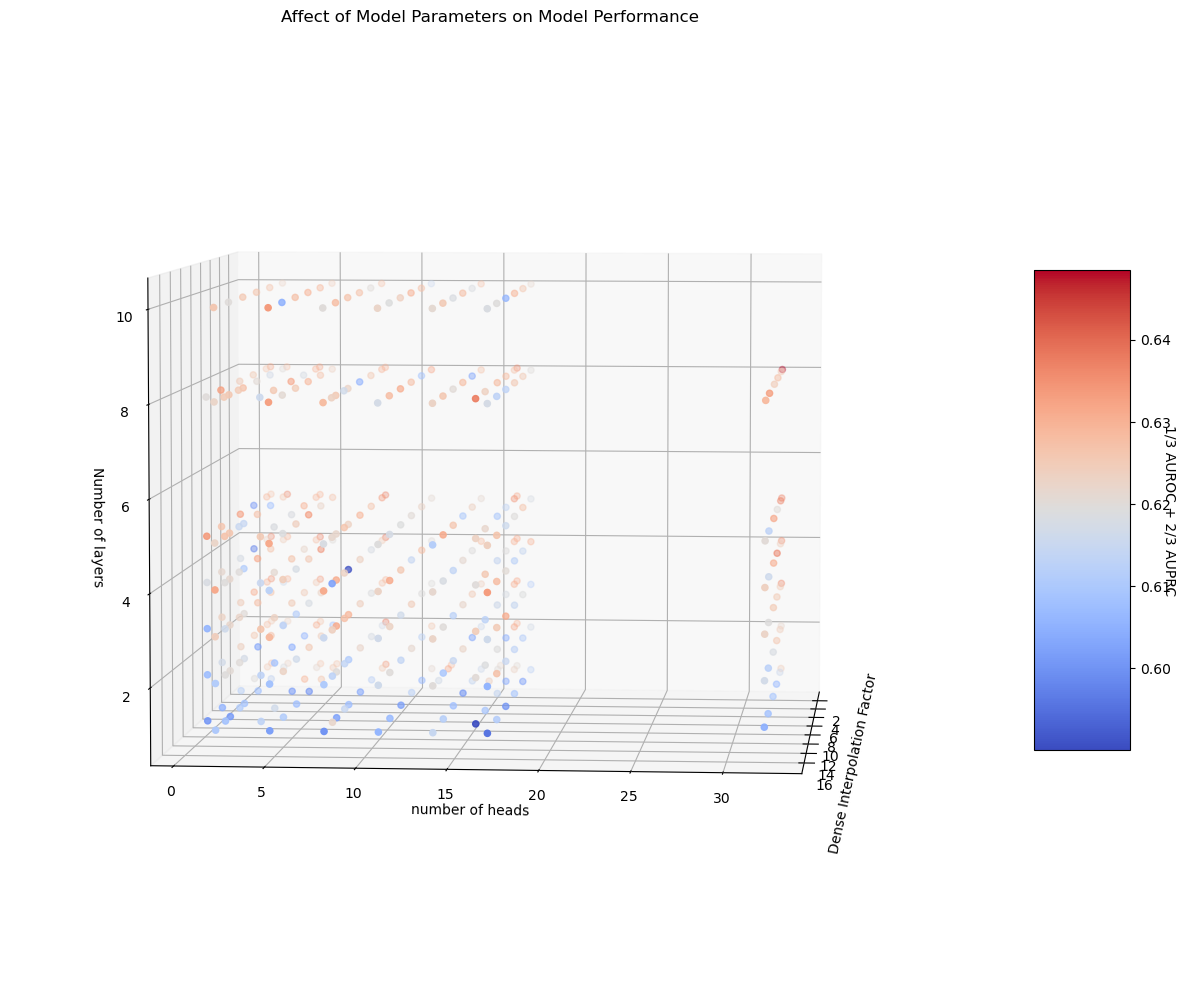

In [225]:
from matplotlib import colors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2], projection="3d")

mixed, auprc, auroc = zip(*scores.values())

x, _, _ = list(zip(*scores.keys()))
lines = {}
for point, score in scores.items():
    layer, factor, head = point
    if layer not in lines:
        lines[layer] = []
    lines[layer].append((factor, head, score[0]))
print(set(x))

scatter = {}
for layer, data in lines.items():
    factors, heads, new_scores = zip(*data)
    scatter = ax.scatter(factors, heads, zs=layer, c=new_scores, cmap=cm.coolwarm, vmin=min(mixed), vmax=max(mixed))
cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('1/3 AUROC + 2/3 AUPRC', rotation=270)


ax.set_title("Affect of Model Parameters on Model Performance")
ax.set_zlabel('Number of layers')
ax.set_xlabel('Dense Interpolation Factor')
ax.set_ylabel('number of heads')

ax.view_init(5, 5)


In [231]:
num_class = 2
epochs = 20
betas = (0.9, 0.98)
lr = 5e-4
eps = 4e-09
weight_decay = 5e-4


experiment = get_experiment()

clf = NeuralNetworkClassifier(
    SAnD(feature_count, seq_len, best_n_heads, best_factor, num_class, best_num_layers, dropout_rate=dropout),
    nn.CrossEntropyLoss(),
    optim.Adam, optimizer_config={
        "lr": lr, "betas": betas, "eps": eps, "weight_decay": weight_decay},
    experiment=experiment,
)
# Score is the multiplication of AUPRC and AUROC
score = clf.fit(
    {
        "train": train_loader,
        "val": val_loader
    },
    validation=True,
    epochs=epochs,
    verbose=True,
)

preds = clf.evaluate(test_loader)

experiment.end()

file_path = 'results/modelstest_predictions.csv'
save_results(test_names, preds, test_raw[1], file_path)
pred_df = pd.read_csv(file_path, index_col=False)
list_df = pd.read_csv(f"mimic3_benchmarks/data/{task}/test_listfile.csv", index_col=False)

evaluate_predictions(pred_df, list_df, save_file="results/optimal_ihm.json")

clf.save_to_file("train/models/", "optimal_ihm.pth")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/samdoud/sand-in-hospital-mortality/6d65b797e4d34027a8d757099e82b00b

Training - Epochs: 001/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2414.96it/s]

Train finished. Accuracy: 0.7911 MSE: 0.2089 AUROC: 0.4976 AUPRC: 0.1736


Training - Epochs: 001/020: 100%|██████████| 14681/14681 [00:06<00:00, 2339.45it/s]


Validation finished. Accuracy: 0.8647 MSE: 0.0297 AUROC: 0.5000 AUPRC: 0.5677


Training - Epochs: 002/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2507.01it/s]

Train finished. Accuracy: 0.8646 MSE: 0.1354 AUROC: 0.5000 AUPRC: 0.0677


Training - Epochs: 002/020: 100%|██████████| 14681/14681 [00:06<00:00, 2425.82it/s]


Validation finished. Accuracy: 0.8647 MSE: 0.0297 AUROC: 0.5000 AUPRC: 0.5677


Training - Epochs: 003/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2517.85it/s]

Train finished. Accuracy: 0.8645 MSE: 0.1355 AUROC: 0.4999 AUPRC: 0.0677


Training - Epochs: 003/020: 100%|██████████| 14681/14681 [00:05<00:00, 2454.29it/s]


Validation finished. Accuracy: 0.8647 MSE: 0.0297 AUROC: 0.5000 AUPRC: 0.5677


Training - Epochs: 004/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2526.93it/s]

Train finished. Accuracy: 0.8646 MSE: 0.1354 AUROC: 0.5000 AUPRC: 0.0677


Training - Epochs: 004/020: 100%|██████████| 14681/14681 [00:06<00:00, 2425.63it/s]


Validation finished. Accuracy: 0.1353 MSE: 0.1898 AUROC: 0.5000 AUPRC: 0.5677


Training - Epochs: 005/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2498.48it/s]

Train finished. Accuracy: 0.8647 MSE: 0.1353 AUROC: 0.5003 AUPRC: 0.5679


Training - Epochs: 005/020: 100%|██████████| 14681/14681 [00:05<00:00, 2450.87it/s]


Validation finished. Accuracy: 0.8647 MSE: 0.0297 AUROC: 0.5000 AUPRC: 0.5677


Training - Epochs: 006/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2528.72it/s]

Train finished. Accuracy: 0.8647 MSE: 0.1353 AUROC: 0.5000 AUPRC: 0.5677


Training - Epochs: 006/020: 100%|██████████| 14681/14681 [00:05<00:00, 2447.94it/s]


Validation finished. Accuracy: 0.8647 MSE: 0.0297 AUROC: 0.5000 AUPRC: 0.5677


Training - Epochs: 007/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2509.63it/s]

Train finished. Accuracy: 0.8646 MSE: 0.1354 AUROC: 0.5019 AUPRC: 0.3065


Training - Epochs: 007/020: 100%|██████████| 14681/14681 [00:06<00:00, 2436.97it/s]


Validation finished. Accuracy: 0.8637 MSE: 0.0299 AUROC: 0.5604 AUPRC: 0.3743


Training - Epochs: 008/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2469.84it/s]

Train finished. Accuracy: 0.8639 MSE: 0.1361 AUROC: 0.5537 AUPRC: 0.3679


Training - Epochs: 008/020: 100%|██████████| 14681/14681 [00:06<00:00, 2433.97it/s]


Validation finished. Accuracy: 0.8740 MSE: 0.0277 AUROC: 0.6011 AUPRC: 0.4605


Training - Epochs: 009/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2524.98it/s]

Train finished. Accuracy: 0.8651 MSE: 0.1349 AUROC: 0.5909 AUPRC: 0.4123


Training - Epochs: 009/020: 100%|██████████| 14681/14681 [00:06<00:00, 2437.51it/s]


Validation finished. Accuracy: 0.8665 MSE: 0.0293 AUROC: 0.6858 AUPRC: 0.5110


Training - Epochs: 010/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2410.22it/s]

Train finished. Accuracy: 0.8769 MSE: 0.1231 AUROC: 0.6226 AUPRC: 0.4856


Training - Epochs: 010/020: 100%|██████████| 14681/14681 [00:06<00:00, 2403.30it/s]


Validation finished. Accuracy: 0.8641 MSE: 0.0298 AUROC: 0.6863 AUPRC: 0.5078


Training - Epochs: 011/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2483.23it/s]

Train finished. Accuracy: 0.8826 MSE: 0.1174 AUROC: 0.6392 AUPRC: 0.5189


Training - Epochs: 011/020: 100%|██████████| 14681/14681 [00:05<00:00, 2447.30it/s]


Validation finished. Accuracy: 0.8731 MSE: 0.0279 AUROC: 0.6548 AUPRC: 0.4952


Training - Epochs: 012/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2498.74it/s]

Train finished. Accuracy: 0.8841 MSE: 0.1159 AUROC: 0.6424 AUPRC: 0.5271


Training - Epochs: 012/020: 100%|██████████| 14681/14681 [00:05<00:00, 2448.38it/s]


Validation finished. Accuracy: 0.8700 MSE: 0.0285 AUROC: 0.6511 AUPRC: 0.4841


Training - Epochs: 013/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2492.87it/s]

Train finished. Accuracy: 0.8849 MSE: 0.1151 AUROC: 0.6567 AUPRC: 0.5357


Training - Epochs: 013/020: 100%|██████████| 14681/14681 [00:05<00:00, 2450.79it/s]


Validation finished. Accuracy: 0.8520 MSE: 0.0325 AUROC: 0.6909 AUPRC: 0.4982


Training - Epochs: 014/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2486.22it/s]

Train finished. Accuracy: 0.8909 MSE: 0.1091 AUROC: 0.6780 AUPRC: 0.5683


Training - Epochs: 014/020: 100%|██████████| 14681/14681 [00:06<00:00, 2437.73it/s]


Validation finished. Accuracy: 0.8681 MSE: 0.0289 AUROC: 0.6558 AUPRC: 0.4843


Training - Epochs: 015/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2434.20it/s]

Train finished. Accuracy: 0.8996 MSE: 0.1004 AUROC: 0.7053 AUPRC: 0.6116


Training - Epochs: 015/020: 100%|██████████| 14681/14681 [00:06<00:00, 2416.97it/s]


Validation finished. Accuracy: 0.8771 MSE: 0.0270 AUROC: 0.6175 AUPRC: 0.4839


Training - Epochs: 016/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2424.42it/s]

Train finished. Accuracy: 0.9043 MSE: 0.0957 AUROC: 0.7258 AUPRC: 0.6351


Training - Epochs: 016/020: 100%|██████████| 14681/14681 [00:06<00:00, 2418.04it/s]


Validation finished. Accuracy: 0.8464 MSE: 0.0337 AUROC: 0.6684 AUPRC: 0.4667


Training - Epochs: 017/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2468.40it/s]

Train finished. Accuracy: 0.9128 MSE: 0.0872 AUROC: 0.7520 AUPRC: 0.6732


Training - Epochs: 017/020: 100%|██████████| 14681/14681 [00:06<00:00, 2446.41it/s]


Validation finished. Accuracy: 0.8411 MSE: 0.0349 AUROC: 0.6518 AUPRC: 0.4418


Training - Epochs: 018/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2501.57it/s]

Train finished. Accuracy: 0.9241 MSE: 0.0759 AUROC: 0.7872 AUPRC: 0.7214


Training - Epochs: 018/020: 100%|██████████| 14681/14681 [00:05<00:00, 2451.83it/s]


Validation finished. Accuracy: 0.8588 MSE: 0.0310 AUROC: 0.5953 AUPRC: 0.3975


Training - Epochs: 019/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2434.45it/s]

Train finished. Accuracy: 0.9270 MSE: 0.0730 AUROC: 0.7958 AUPRC: 0.7332


Training - Epochs: 019/020: 100%|██████████| 14681/14681 [00:06<00:00, 2442.88it/s]


Validation finished. Accuracy: 0.8551 MSE: 0.0318 AUROC: 0.6047 AUPRC: 0.4008


Training - Epochs: 020/020:  99%|█████████▉| 14592/14681 [00:05<00:00, 2439.06it/s]

Train finished. Accuracy: 0.9354 MSE: 0.0646 AUROC: 0.8206 AUPRC: 0.7668


Training - Epochs: 020/020: 100%|██████████| 14681/14681 [00:06<00:00, 2397.87it/s]


Validation finished. Accuracy: 0.8637 MSE: 0.0299 AUROC: 0.6030 AUPRC: 0.4203


Evaluating: 100%|██████████| 3236/3236 [00:00<00:00, 6644.74it/s]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/samdoud/sand-in-hospital-mortality/6d65b797e4d34027a8d757099e82b00b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_AUPRC                 : 1.0
COMET INFO:     test_AUROC                 : 1.0
COMET INFO:     test_MSE [13]              : (0.11328125, 0.12571022727272727)
COMET INFO:     test_accuracy [13]         : (0.8742897727272727, 0.88671875)
COMET INFO:     test_loss [13]             : (0.3616727888584137, 4.995124578475952)
COMET INFO:     train_AUPRC [1160]         : (0.06676136363636363, 0.8067697298728813)
COMET INFO:     train_AUROC [1160]         : (0.48997621016954634, 0.8468446363725587)
COMET INFO:     train_MSE [1160]           : (0.05859375, 0.851562

Evaluation finished. Accuracy: 0.8786 MSE: 0.1214 AUROC: 1.0000 AUPRC: 1.0000


COMET INFO: Uploading 1 metrics, params and output messages


Saving the results in results/optimal_ihm.json ...
{'n_iters': 10000, 'AUC of ROC': {'value': 0.6001160326909495, 'mean': 0.600206587810774, 'median': 0.5999233539070996, 'std': 0.011214270506389129, '2.5% percentile': 0.5784176540977234, '97.5% percentile': 0.6223031921716695}, 'AUC of PRC': {'value': 0.3889081288166989, 'mean': 0.38929684186203795, 'median': 0.38964300460870316, 'std': 0.026202804082092104, '2.5% percentile': 0.3365138095446701, '97.5% percentile': 0.43918503781997414}, 'min(+P, Se)': {'value': 0.23796791443850268, 'mean': 0.23811358114064723, 'median': 0.23783783783783785, 'std': 0.022114526849024718, '2.5% percentile': 0.19483801337153772, '97.5% percentile': 0.28205128205128205}}


'train/models/optimal_ihm.pth'